In [192]:
import pandas as pd
import numpy as np
import warnings
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

OAK = 'FOAK'
with_PTC = False
cogen = True
cambium_scenario = 'MidCase'
year = 2024
if cogen: cogen_tag = 'cogen'
else: cogen_tag = 'nocogen'
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Import ANR-H2 input parameters

In [193]:
h2_techs = pd.read_excel('./h2_tech.xlsx', sheet_name = 'Summary')
h2_techs.rename(columns={'CAPEX ($/MWe)':'H2 CAPEX ($/MWe)',
                 'FOM ($/MWe-year)':'H2 FOM ($/MWe-year)',
                 'VOM ($/MWhe)':'H2 VOM ($/MWhe)'}, inplace=True)
anrs = pd.read_excel('./ANRs.xlsx', sheet_name=OAK)
anrs.rename(columns={'CAPEX $/MWe':'ANR CAPEX ($/MWe)',
                 'FOPEX $/MWe-y':'ANR FOM ($/MWe-year)',
                 'VOM in $/MWh-e':'ANR VOM ($/MWhe)', 
                 'Startupfixedcost in $':'Start Cost ($)'}, inplace=True)
techs = pd.merge(h2_techs, anrs, left_on='ANR', right_on='Reactor')

# Natural Gas

In [194]:
# Avoided NG costs
def compute_ng_multiplier(temp, AHF_coeffs=[0, -.00038, 0.90556]):
  # Available Heat Fraction
  AHF = AHF_coeffs[0]*(int(temp)**2)+ AHF_coeffs[1]*int(temp) + AHF_coeffs[2]
  multiplier = AHF/utils.mmbtu_to_mj # Unit: MmBtu/MJ
  return multiplier

# Merge state-level prices
ng_prices = pd.read_excel('./input_data/eia_aeo_industrial_sector_ng_prices.xlsx', sheet_name='state_prices')
# 2024 prices
ng_prices = ng_prices[ng_prices.year == 2024]
ng_prices.rename(columns={'price 2020USD/MMBtu':'NG price ($/MMBtu)'}, inplace=True)

# Coordinates

In [195]:
locations_file = './results/process_heat/heat_facilities_locations.csv'
if not os.path.isfile(locations_file):
  loc_data = pd.read_excel('./input_data/direct_heat_maxv/facs_batched.xlsx')[['CITY', 'STATE']].drop_duplicates(ignore_index=True)
  geolocator = Nominatim(user_agent="your_app_name")
  geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

  # Function to apply geocoding
  def geocode_location(row):
      # Try to geocode using city and state, else return NaN
      try:
          location = geocode(f"{row['CITY']}, {row['STATE']}, USA")
          return location.latitude, location.longitude
      except:
          return pd.NA, pd.NA

  # Apply the geocoding function to each row
  loc_data['latitude'], loc_data['longitude'] = zip(*loc_data.apply(geocode_location, axis=1))
  loc_data.to_csv(locations_file, index=False)
else:
  loc_data = pd.read_csv(locations_file)

In [196]:
loc_data

,CITY,STATE,latitude,longitude
0,East Chicago,IN,41.639786,-87.454847
1,CLEVELAND,OH,41.499657,-81.693677
2,BURNS HARBOR,IN,41.625871,-87.133368
3,MIDDLETOWN,OH,39.516644,-84.404173
4,DEARBORN,MI,42.322260,-83.176315
...,...,...,...,...
745,WEST BURLINGTON,IA,40.825083,-91.156550
746,GIBSON CITY,IL,40.465312,-88.375888
747,JACKSON,NE,42.448296,-96.565531
748,ST ANSGAR (MONA),IA,NaN,NaN


# ANR +  ANR-H2 Analysis

## Load batched NREL data from MAX

In [197]:
nrel_data = pd.read_excel('./input_data/direct_heat_maxv/facs_batched.xlsx')
nrel_data.drop(columns=['Unnamed: 0', 'Total'], inplace=True)
nrel_data.columns

Index(['CITY', 'COUNTY', 'COUNTY_FIPS', 'Coal', 'Diesel', 'END_USE',
       'FACILITY_ID', 'FINAL_NAICS_CODE', 'FUEL_TYPE', 'FUEL_TYPE_BLEND',
       'FUEL_TYPE_OTHER', 'LPG_NGL', 'MECS_NAICS', 'Natural_gas', 'Other',
       'Process_byp', 'Pulp_Paper', 'REPORTING_YEAR', 'Residual_fuel_oil',
       'STATE', 'Temp_degC', 'UNIT_NAME', 'UNIT_TYPE', 'for_EU_sum',
       'Temp_Band', 'Biogenic', 'MMTCO2E', 'Batch_Temp_degC',
       'Highest_Temp_served_degC', 'Emissions_mmtco2/y', 'Heat_demand_MWh/hr',
       'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod',
       'Helper'],
      dtype='object')

In [198]:
# Load results from MAX
max_results = pd.read_csv('./input_data/direct_heat_maxv/Full_Spread_SMRs.csv')
max_results.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
assert len(max_results) <= len(nrel_data)*5
max_results.columns

Index(['CITY', 'COUNTY', 'COUNTY_FIPS', 'Coal', 'Diesel', 'END_USE',
       'FACILITY_ID', 'FINAL_NAICS_CODE', 'FUEL_TYPE', 'FUEL_TYPE_BLEND',
       'FUEL_TYPE_OTHER', 'LPG_NGL', 'MECS_NAICS', 'Natural_gas', 'Other',
       'Process_byp', 'Pulp_Paper', 'REPORTING_YEAR', 'Residual_fuel_oil',
       'STATE', 'Temp_degC', 'Total', 'UNIT_NAME', 'UNIT_TYPE', 'for_EU_sum',
       'Temp_Band', 'Biogenic', 'MMTCO2E', 'Batch_Temp_degC',
       'Highest_Temp_served_degC', 'Emissions_mmtco2/y', 'Heat_demand_MWh/hr',
       'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod',
       'Helper', 'Reactor', 'Power in MWt', 'Thermal Efficiency',
       'Outlet Temp (C)', 'CAPEX $/MWe_foak', 'FOPEX $/MWe-y_foak',
       'VOM in $/MWh-e_foak', 'CAPEX $/MWe', 'FOPEX $/MWe-y', 'VOM in $/MWh-e',
       'Life (y)', 'Modules', 'SMR_Capacity', 'SMR_Capacity_e',
       'Surplus_Capacity', 'Surplus_Capacity_e', 'CRF', 'Total_CAPEX_FOAK',
       'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK', 

In [199]:
max_results[['Remaining_temp_degC', 'Batch_Temp_degC']]

,Remaining_temp_degC,Batch_Temp_degC
0,1100.0,180.0
1,1100.0,180.0
2,1100.0,180.0
3,1100.0,180.0
4,1100.0,180.0
...,...,...
6783,0.0,233.0
6784,0.0,233.0
6785,0.0,233.0
6786,0.0,233.0


## Compute H2 demand for unserved demand

In [200]:
def compute_h2_demand(heat, temp, AHF_coeffs = [0, -0.00038, .90556]):
  """Computes the equivalent hydrogen demand to produce heat 
  Args:
    - heat (float): heat demand in MW
    - temp (float): temperature in degree Celsius
    - AHF_coeffs (list(float)): coefficients for Available Heat Fraction calculation
  Returns:
    - h2_demand (float): hydrogen demand in kg/h
  """
  AHF = AHF_coeffs[0]*(int(temp)^2) + AHF_coeffs[1]*int(temp) + AHF_coeffs[2]
  h2_demand = heat*utils.mwh_to_mj/(utils.h2_hhv*AHF)
  return h2_demand
max_results['Remaining H2 Dem. (kg/h)'] = max_results.apply(lambda x:compute_h2_demand(x['Remaining_Heat_MW'], x['Remaining_temp_degC']), axis=1)

## Compute ANR Net Annual Revenues from Max results for FOAK/NOAK

In [201]:
max_results[f'ANR Net Ann. Rev. {OAK} ($/year)'] = -(max_results[f'Annual_CAPEX_{OAK}']+max_results[f'FOPEX_{OAK}']+max_results[f'VOPEX_{OAK}'])+\
                                                    max_results['Revenues']
max_results[f'ANR only Cost {OAK} ($/year)'] = max_results[f'Annual_CAPEX_{OAK}']+max_results[f'FOPEX_{OAK}']+max_results[f'VOPEX_{OAK}']

In [202]:
ng_df = max_results[['FACILITY_ID','STATE','CITY','Batch_Temp_degC', 'Highest_Temp_served_degC', 'Emissions_mmtco2/y',\
                    'Heat_demand_MWh/hr', 'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod', 'Reactor',\
                    'Modules', 'SMR_Capacity', 'SMR_Capacity_e','Surplus_Capacity', 'Surplus_Capacity_e', \
                    f'Annual_CAPEX_{OAK}', f'FOPEX_{OAK}', f'VOPEX_{OAK}', f'Annual_Cost_{OAK}', f'Total_CAPEX_{OAK}',f'ANR only Cost {OAK} ($/year)',
                    'NG price ($/MMBtu)', 'Revenues', f'ANR Net Ann. Rev. {OAK} ($/year)', 'Remaining H2 Dem. (kg/h)']]
ng_df.to_csv(f'./results/process_heat/max_results_full_{OAK}.csv')

## Map emissions to batch or max temp

In [203]:
# Compute the ratio of NG burned for batch temperature and remaining temperature demand
ng_df['NG_batch'] = ng_df.apply(lambda x:compute_ng_multiplier(x['Batch_Temp_degC'])*x['Heat_demand_MWh/hr'], axis=1)
ng_df['NG_rem'] = ng_df.apply(lambda x:compute_ng_multiplier(x['Remaining_temp_degC'])*x['Remaining_Heat_MW'], axis=1)
ng_df['NG_batch_ratio'] = ng_df['NG_batch']/(ng_df['NG_batch']+ng_df['NG_rem'])
ng_df['NG_rem_ratio'] = ng_df['NG_rem']/(ng_df['NG_batch']+ng_df['NG_rem'])
ng_df['Emissions_batch_mmtco2/y'] = ng_df['NG_batch_ratio']*ng_df['Emissions_mmtco2/y']
ng_df['Emissions_rem_mmtco2/y'] = ng_df['NG_rem_ratio']*ng_df['Emissions_mmtco2/y']

## Compute ANR deployment and cashflows

In [204]:
fr = ng_df.merge(techs, left_on='Reactor', right_on='ANR') # facilities remaining demand
fr.columns


Index(['FACILITY_ID', 'STATE', 'CITY', 'Batch_Temp_degC',
       'Highest_Temp_served_degC', 'Emissions_mmtco2/y', 'Heat_demand_MWh/hr',
       'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod',
       'Reactor_x', 'Modules', 'SMR_Capacity', 'SMR_Capacity_e',
       'Surplus_Capacity', 'Surplus_Capacity_e', 'Annual_CAPEX_FOAK',
       'FOPEX_FOAK', 'VOPEX_FOAK', 'Annual_Cost_FOAK', 'Total_CAPEX_FOAK',
       'ANR only Cost FOAK ($/year)', 'NG price ($/MMBtu)', 'Revenues',
       'ANR Net Ann. Rev. FOAK ($/year)', 'Remaining H2 Dem. (kg/h)',
       'NG_batch', 'NG_rem', 'NG_batch_ratio', 'NG_rem_ratio',
       'Emissions_batch_mmtco2/y', 'Emissions_rem_mmtco2/y', 'Technology',
       'ANR', 'H2Cap (MWe)', 'H2Cap (kgh2/h)', 'H2ElecCons (MWhe/kgh2)',
       'H2HeatCons (MWht/kgh2)', 'Eq tot H2ElecCons (MWhe/kgh2)',
       'Eq tot H2HeatCons (MWht/kgh2)', 'H2 CAPEX ($/MWe)',
       'H2 FOM ($/MWe-year)', 'H2 VOM ($/MWhe)', 'Life (y)_x', 'ANR Th Eff',
       'Carbon inte

In [205]:
import math
fr['H2 Modules'] = fr.apply(lambda x: math.ceil(x['Remaining H2 Dem. (kg/h)']/x['H2Cap (kgh2/h)']), axis=1)
fr['Depl. H2 Cap. (kgh2/h)'] = fr['H2 Modules']*fr['H2Cap (kgh2/h)']
fr['Depl. H2 Cap. (MWe)'] = fr['H2 Modules']*fr['H2Cap (MWe)']
fr['ANR Modules'] = fr.apply(lambda x: math.ceil(x['Depl. H2 Cap. (MWe)']/x['Power in MWe']), axis=1)
fr['Depl. ANR Cap. (MWe)'] = fr['ANR Modules']*fr['Power in MWe']
fr['Depl. ANR Cap. (MWt)'] = fr['ANR Modules']*fr['Power in MWt']
fr['Surplus SMR Cap. (MWe)'] = fr['Depl. ANR Cap. (MWe)']-fr['Depl. H2 Cap. (MWe)']
fr['Surplus ANR Cap. (MWt)'] = fr['Surplus SMR Cap. (MWe)']/fr['Thermal Efficiency']

In [206]:
# Compute costs in $/year
# Capital recovery factor
IR = utils.WACC
fr['ANR CRF'] = (IR/(1-((1+IR)**(-1*(fr['Life (y)_y'])))))
fr['H2 CRF'] = (IR/(1-((1+IR)**(-1*(fr['Life (y)_x'])))))
itc_anr = utils.ITC_ANR
itc_h2 = utils.ITC_H2

## CAPEX
fr['Tot ANR CAPEX'] = fr['Depl. ANR Cap. (MWe)']*fr['ANR CAPEX ($/MWe)']*(1-itc_anr)
fr['Annual ANR CAPEX'] = fr['Tot ANR CAPEX']*fr['ANR CRF']
fr['Tot H2 CAPEX'] = fr['Depl. H2 Cap. (MWe)']*fr['H2 CAPEX ($/MWe)']*(1-itc_h2)
fr['Annual H2 CAPEX'] = fr['Tot H2 CAPEX']*fr['H2 CRF']
fr['Annual ANR-H2 CAPEX'] = fr['Annual ANR CAPEX']+fr['Annual H2 CAPEX']

## FOM
fr['ANR FOM'] = fr['Depl. ANR Cap. (MWe)']*fr['ANR FOM ($/MWe-year)']
fr['H2 FOM'] = fr['Depl. H2 Cap. (MWe)']*fr['H2 FOM ($/MWe-year)']
fr['ANR-H2 FOM'] = fr['ANR FOM']+fr['H2 FOM']

## VOM
fr['ANR VOM'] =fr['Remaining H2 Dem. (kg/h)']*8760*fr['Eq tot H2ElecCons (MWhe/kgh2)']*fr['ANR VOM ($/MWhe)']
fr['H2 VOM'] =fr['Remaining H2 Dem. (kg/h)']*8760*fr['H2 VOM ($/MWhe)']
fr['ANR-H2 VOM'] = fr['ANR VOM']+fr['H2 VOM']

## Conversion costs
gf_crf = IR/ (1 - (1/(1+IR)**utils.GFLT) ) 
fr['Conversion'] = utils.GFCAPEX*gf_crf*(1-itc_h2)*fr['Remaining_Heat_MW']
fr['Conversion total'] = utils.GFCAPEX*(1-itc_h2)*fr['Remaining_Heat_MW']

# Initial investment 
fr['Initial investment ($)'] = fr['Conversion total']+fr['Tot ANR CAPEX']+fr['Tot H2 CAPEX']+fr[f'Total_CAPEX_{OAK}']

# Total cost
fr['ANR-H2 Total Cost ($/year)'] = fr['Annual ANR-H2 CAPEX'] + fr['ANR-H2 FOM'] + fr['ANR-H2 VOM'] + fr['Conversion']


In [207]:
# Compute revenues in $/year
# Avoided NG costs
fr['NG Mult (MMBtu/MJ)'] = fr.apply(lambda x: compute_ng_multiplier(x['Remaining_temp_degC']), axis=1) 

fr['Avoided NG Cost'] = fr['NG price ($/MMBtu)']*fr['NG Mult (MMBtu/MJ)']*fr['Remaining_Heat_MW']*utils.mwh_to_mj*8760
# Total avoided NG cost
fr['Avoided NG Cost ($/y)'] = fr['Avoided NG Cost']+fr['Revenues']

# H2 PTC
fr['H2 PTC'] = utils.h2_ptc*fr['Remaining H2 Dem. (kg/h)']*8760

# Compute total deployed ANR capacity 
fr['Depl. ANR Cap. (MWe)'] = fr['Depl. ANR Cap. (MWe)']+fr[ 'SMR_Capacity_e']
fr['Depl. ANR Cap. (MWt)'] = fr['Depl. ANR Cap. (MWt)']+fr[ 'SMR_Capacity']
fr['Surplus SMR Cap. (MWe)'] = fr['Surplus SMR Cap. (MWe)']+fr['Surplus_Capacity_e']
fr['Surplus ANR Cap. (MWt)'] = fr['Surplus ANR Cap. (MWt)']+fr['Surplus_Capacity']
fr['ANR Modules'] = fr['ANR Modules']+fr['Modules']


In [208]:
def compute_average_electricity_prices(cambium_scenario, year):
  folder = f'./input_data/cambium_{cambium_scenario.lower()}_state_hourly_electricity_prices'
  list_csv_files = glob.glob(folder+'/Cambium*.csv')
  state_prices = pd.DataFrame(columns=['average price ($/MWhe)', 'state'])
  state_prices.set_index('state', inplace=True)
  for file in list_csv_files:
    if str(year) in file:
      state = file.split('_')[-2]
      avg_price = pd.read_csv(file, skiprows=5)['energy_cost_enduse'].mean()
      state_prices.loc[state, 'average price ($/MWhe)'] = avg_price
  state_prices.to_excel(f'./results/average_electricity_prices_{cambium_scenario}_{year}.xlsx')


def compute_cogen(df, surplus_cap_col_name, state_col_name):
  try:
    elec_prices_df = pd.read_excel(f'./results/average_electricity_prices_{cambium_scenario}_{year}.xlsx', index_col=0)
  except FileNotFoundError:
    compute_average_electricity_prices(cambium_scenario, year)
    elec_prices_df = pd.read_excel(f'./results/average_electricity_prices_{cambium_scenario}_{year}.xlsx', index_col=0)
  df['Electricity revenues ($/y)'] = df.apply(lambda x: x[surplus_cap_col_name]*elec_prices_df.loc[x[state_col_name]]*8760, axis=1)
  return df
  

In [209]:
# Revenues = - (Cost of ANR+Cost of ANR-H2)+ Avoided cost of NG +H2 PTC Revenues
if with_PTC:
  fr['Net Ann. Rev. ($/year)'] = -fr['ANR-H2 Total Cost ($/year)']+fr['H2 PTC']+fr['Avoided NG Cost']\
                                      +fr[f'ANR Net Ann. Rev. {OAK} ($/year)']
else:
  fr['Net Ann. Rev. ($/year)'] = -fr['ANR-H2 Total Cost ($/year)']+fr['Avoided NG Cost']\
                                      +fr[f'ANR Net Ann. Rev. {OAK} ($/year)']
if cogen: 
  fr = compute_cogen(fr, 'Surplus SMR Cap. (MWe)', 'STATE')
  fr['Net Ann. Rev. ($/year)'] += fr['Electricity revenues ($/y)']

fr.to_csv(f'./results/process_heat/anr+anrh2_full_{OAK}_{cogen_tag}_PTC_{with_PTC}.csv')


In [210]:
# Select best hydrogen technology
# Select h2 tech corresponding to the maximum net annual revenue
fr.reset_index(inplace=True, drop=True)
idx = fr.groupby(['FACILITY_ID', 'Remaining_temp_degC', 'ANR'])['Net Ann. Rev. ($/year)'].idxmax()
max_h2 = fr.loc[idx]
print(len(fr), len(max_h2))
fr = max_h2  

20364 6788


In [211]:


fr.drop(columns=['SMR_Capacity_e', 'SMR_Capacity', 'Surplus_Capacity', 'Surplus_Capacity_e','H2 CRF',  'H2Cap (MWe)',
       'H2Cap (kgh2/h)', 'H2ElecCons (MWhe/kgh2)', 'H2HeatCons (MWht/kgh2)',
       'Eq tot H2ElecCons (MWhe/kgh2)', 'Eq tot H2HeatCons (MWht/kgh2)',
       'H2 CAPEX ($/MWe)', 'H2 FOM ($/MWe-year)', 'H2 VOM ($/MWhe)',
       'Life (y)_x', 'ANR Th Eff', 'Reactor_y','Reactor_x', 'Type', 'Power in MWe', 'Power in MWt', 'MSL in MWe',
       'Thermal Efficiency', 'Thermal transfer efficiency', 'MDT in hours',
       'Ramp Rate (fraction of capacity/hr)', 'Ramp Rate (MW/hr)',
       'Outlet Temp (C)','ANR FOM ($/MWe-year)',
       'Max Modules', 'ANR VOM ($/MWhe)', 'Start Cost ($)', 'Life (y)_y', 'Avoided NG Cost', 'Revenues',
       'Modules',  'NG_batch','NG_rem', 'NG_batch_ratio', 'NG_rem_ratio',], inplace=True)


In [212]:
# Compute IRR
fr['IRR w PTC'] = fr.apply(lambda x: utils.calculate_irr(x['Initial investment ($)'], x['Electricity revenues ($/y)'], x['H2 PTC'], x['Avoided NG Cost ($/y)']), axis=1)
fr['IRR wo PTC'] = fr.apply(lambda x: utils.calculate_irr(x['Initial investment ($)'], x['Electricity revenues ($/y)'], x['H2 PTC'], x['Avoided NG Cost ($/y)'], ptc=False), axis=1)


In [213]:
fr.to_csv(f'./results/process_heat/anr+anrh2_after_h2_opt_{OAK}_{cogen_tag}_PTC_{with_PTC}.csv')

## Select best ANR design for each facility

In [214]:
# Select ANR design corresponding to the maximum net annual revenue
fr.reset_index(inplace=True, drop=True)
idx = fr.groupby(['FACILITY_ID'])['Net Ann. Rev. ($/year)'].idxmax()
max_anr = fr.loc[idx]
print(len(fr), len(max_anr))
fr = max_anr.reset_index(drop=True)     
fr

6788 913


,FACILITY_ID,STATE,CITY,Batch_Temp_degC,Highest_Temp_served_degC,Emissions_mmtco2/y,Heat_demand_MWh/hr,Remaining_Heat_MW,Remaining_temp_degC,Temp_Req,...,Conversion total,Initial investment ($),ANR-H2 Total Cost ($/year),NG Mult (MMBtu/MJ),Avoided NG Cost ($/y),H2 PTC,Net Ann. Rev. ($/year),Electricity revenues ($/y),IRR w PTC,IRR wo PTC
0,1000022,TX,TEXAS CITY,260.000000,260,0.021183,14.677033,4.949232,900.0,301,...,4.642380e+06,1.296695e+08,1.317861e+07,0.000534,2.601209e+06,5.856044e+06,-1.649295e+07,8.428740e+05,-0.00,-0.05
1,1000025,LA,PORT ALLEN,457.187911,600,0.050151,34.747554,0.000000,0.0,629,...,0.000000e+00,5.768310e+08,0.000000e+00,0.000858,5.897046e+06,0.000000e+00,-4.913940e+06,3.427753e+07,0.03,0.03
2,1000029,WA,SEATTLE,180.000000,180,0.005027,3.483160,23.098853,1100.0,301,...,2.166672e+07,1.036646e+09,6.019711e+07,0.000462,2.628773e+06,3.159141e+07,-4.541806e+07,5.575849e+07,0.04,0.01
3,1000035,OH,GREENVILLE,382.244726,450,0.173995,120.554648,0.000000,0.0,629,...,0.000000e+00,3.655200e+08,0.000000e+00,0.000858,2.461294e+07,0.000000e+00,5.219656e+04,8.864916e+06,0.07,0.07
4,1000041,WI,MILWAUKEE,328.087109,505,0.029349,20.335118,7.202021,800.0,629,...,6.755496e+06,9.967409e+08,4.799215e+07,0.000570,4.705563e+06,7.983294e+06,-1.933629e+07,6.835642e+07,0.05,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,1011979,IN,Valparaiso,310.329136,505,0.017979,12.456710,6.467907,800.0,629,...,6.066897e+06,9.950109e+08,4.751000e+07,0.000570,3.050262e+06,7.169543e+06,-1.509935e+07,7.339348e+07,0.05,0.04
909,1012002,OH,Cincinnati,328.087109,505,0.000226,0.156726,0.055507,800.0,629,...,5.206572e+04,9.810685e+08,4.357901e+07,0.000570,3.626655e+04,6.152856e+04,-6.974314e+06,8.001915e+07,0.05,0.05
910,1012019,IA,Tama,328.087109,505,0.017325,12.004109,4.251455,800.0,629,...,3.987865e+06,1.286911e+08,1.198723e+07,0.000570,2.487399e+06,4.712652e+06,-1.486086e+07,1.397395e+06,-0.00,-0.04
911,1012036,NE,Mead,382.244726,450,0.022998,15.934422,0.000000,0.0,629,...,0.000000e+00,7.195320e+07,0.000000e+00,0.000858,2.913175e+06,0.000000e+00,-3.570835e+06,2.744148e+05,-0.01,-0.01


In [215]:
fr['Pathway'] = 'SMR+SMR-H2'
fr['Pathway Net Ann. Rev. ($/year)'] = fr['Net Ann. Rev. ($/year)']
fr = fr.merge(loc_data, on=['CITY', 'STATE'])
fr.to_csv(f'./results/process_heat/anr+anrh2_best_{OAK}_{cogen_tag}_PTC_{with_PTC}.csv')

In [216]:
type(fr['Heat_demand_MWh/hr'].iloc[0])

numpy.float64

In [217]:
fr.columns

Index(['FACILITY_ID', 'STATE', 'CITY', 'Batch_Temp_degC',
       'Highest_Temp_served_degC', 'Emissions_mmtco2/y', 'Heat_demand_MWh/hr',
       'Remaining_Heat_MW', 'Remaining_temp_degC', 'Temp_Req', 'NG_HLMP_mod',
       'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK', 'Annual_Cost_FOAK',
       'Total_CAPEX_FOAK', 'ANR only Cost FOAK ($/year)', 'NG price ($/MMBtu)',
       'ANR Net Ann. Rev. FOAK ($/year)', 'Remaining H2 Dem. (kg/h)',
       'Emissions_batch_mmtco2/y', 'Emissions_rem_mmtco2/y', 'Technology',
       'ANR', 'Carbon intensity (kgCO2eq/kgH2)', 'ANR CAPEX ($/MWe)',
       'H2 Modules', 'Depl. H2 Cap. (kgh2/h)', 'Depl. H2 Cap. (MWe)',
       'ANR Modules', 'Depl. ANR Cap. (MWe)', 'Depl. ANR Cap. (MWt)',
       'Surplus SMR Cap. (MWe)', 'Surplus ANR Cap. (MWt)', 'ANR CRF',
       'Tot ANR CAPEX', 'Annual ANR CAPEX', 'Tot H2 CAPEX', 'Annual H2 CAPEX',
       'Annual ANR-H2 CAPEX', 'ANR FOM', 'H2 FOM', 'ANR-H2 FOM', 'ANR VOM',
       'H2 VOM', 'ANR-H2 VOM', 'Conversion', 'Con

In [218]:
fr[['NG_HLMP_mod', 'NG Mult (MMBtu/MJ)']]

,NG_HLMP_mod,NG Mult (MMBtu/MJ)
0,4.290944,0.000534
1,4.729829,0.000858
2,4.133250,0.000462
3,4.552554,0.000858
4,4.432928,0.000570
...,...,...
908,4.394437,0.000570
909,4.432928,0.000570
910,4.432928,0.000570
911,4.552554,0.000858


In [219]:
# Compute breakeven ng price
if cogen: 
  fr['Breakeven NG price ($/MMBtu)'] = (fr['Annual ANR-H2 CAPEX']+fr['ANR-H2 FOM']+fr['ANR-H2 FOM']+fr['Conversion']+fr[f'ANR only Cost {OAK} ($/year)']\
                                                -fr['H2 PTC']-fr['Electricity revenues ($/y)'])/\
                                              (fr['NG_HLMP_mod']*(fr['Heat_demand_MWh/hr']+fr['Remaining_Heat_MW'])*8760)
  fr['BE wo PTC ($/MMBtu)'] = (fr['Annual ANR-H2 CAPEX']+fr['ANR-H2 FOM']+fr['ANR-H2 FOM']+fr['Conversion']+fr[f'ANR only Cost {OAK} ($/year)']\
                                                -fr['Electricity revenues ($/y)'])/(fr['NG_HLMP_mod']*(fr['Heat_demand_MWh/hr']+fr['Remaining_Heat_MW'])*8760)
else: 
  fr['Breakeven NG price ($/MMBtu)'] = (fr['Annual ANR-H2 CAPEX']+fr['ANR-H2 FOM']+fr['ANR-H2 FOM']+fr['Conversion']+fr[f'ANR only Cost {OAK} ($/year)']\
                                                -fr['H2 PTC'])/(fr['NG_HLMP_mod']*(fr['Heat_demand_MWh/hr']+fr['Remaining_Heat_MW'])*8760)
  fr['BE wo PTC ($/MMBtu)'] = (fr['Annual ANR-H2 CAPEX']+fr['ANR-H2 FOM']+fr['ANR-H2 FOM']+fr['Conversion']+fr[f'ANR only Cost {OAK} ($/year)'])/\
                                             (fr['NG_HLMP_mod']*(fr['Heat_demand_MWh/hr']+fr['Remaining_Heat_MW'])*8760)

In [220]:
print(len(fr[fr['BE wo PTC ($/MMBtu)']<=fr['NG price ($/MMBtu)']]))

33


In [221]:
fr[fr['Pathway Net Ann. Rev. ($/year)']>0][['Breakeven NG price ($/MMBtu)', 'BE wo PTC ($/MMBtu)', 'NG price ($/MMBtu)']]
print(len(fr[fr['Pathway Net Ann. Rev. ($/year)']>0]))

33


# ANR-H2 Analysis

## Load demand data

In [222]:
nrel_data = pd.read_csv('./input_data/direct_heat_maxv/NREL_base_facilities_2.csv', encoding = "ISO-8859-1")
nrel_data.columns
nrel_data = nrel_data[['FACILITY_ID', 'FUEL_TYPE',
       'FUEL_TYPE_BLEND', 'FUEL_TYPE_OTHER', 
       'Natural_gas', 'Other', 'REPORTING_YEAR', 'CITY',
       'STATE', 'Temp_degC', 'Total', 'UNIT_NAME', 'MMTCO2E']]
nrel_data = nrel_data.loc[nrel_data.FUEL_TYPE.isin(['Natural Gas (Weighted U.S. Average)'])]
nrel_data = nrel_data[nrel_data.REPORTING_YEAR ==2015]
nrel_data.drop(nrel_data.index[(nrel_data["Total"] ==0)],axis=0,inplace=True)
nrel_data.drop(columns=['FUEL_TYPE',
       'FUEL_TYPE_BLEND', 'FUEL_TYPE_OTHER', 
       'Natural_gas', 'Other', 'REPORTING_YEAR'], inplace=True)
# Group units with same temperature in same facility
nrel_data['Heat Demand (MW)'] = nrel_data.apply(lambda x: x['Total']*1.1*277.778/8670, axis=1)
nrel_data = nrel_data.groupby(['FACILITY_ID', 'STATE', 'CITY', 'Temp_degC']).sum(numeric_only=True)
# compute MW from Total in TJ/y, distribution losses add 10%

nrel_data.reset_index(inplace=True)
print(max(nrel_data['Heat Demand (MW)']))
print(min(nrel_data['Heat Demand (MW)']))

2092.923621721449
0.0005791400666693657


## Compute total equivalent Hydrogen demand

In [223]:
# For each facility, temperature and heat compute hydrogen demand and sum up for each facility (sum emissions too)
nrel_data['Total H2 Dem. (kg/h)'] = nrel_data.apply(lambda x:compute_h2_demand(x['Heat Demand (MW)'], x['Temp_degC']), axis=1)
def NGTempCostCurve(Temp,NG_Cost = 1.0, AHF_Coeffs = [0,-0.00038,0.90556]):
    HHV = 54 # MJ/kg
    Density = 0.68 # kg/m3
    cfTom3 = 35.31 # Unit conversion
    AHF = AHF_Coeffs[0]*(int(Temp)^2) + AHF_Coeffs[1]*int(Temp) + AHF_Coeffs[2] # avaialble Heat fraction - Deep Patel Equation
    
    HHV = HHV*Density*(1/cfTom3)*(1/1000000)*(1000) # returns  TJ/thousand cf 
    Cost = NG_Cost*(1/HHV)*(1/AHF)*(1/277.778) # returns the Cost in $/MWh
    return Cost
nrel_data['NG_HLMP_mod'] = nrel_data.apply(lambda x: NGTempCostCurve(x['Temp_degC']), axis=1) 
nrel_data = nrel_data.merge(ng_prices, left_on='STATE', right_on='state')
nrel_data['Avoided NG Cost ($/y)'] = nrel_data['NG price ($/MMBtu)']*nrel_data['NG_HLMP_mod']*nrel_data['Heat Demand (MW)']*8760


In [224]:
# Get temperatures stats
temps = nrel_data[['FACILITY_ID', 'Temp_degC']]
max_temp = temps.groupby(['FACILITY_ID']).max()
max_temp.rename(columns={'Temp_degC':'max_temp_degC'}, inplace=True)
max_temp.reset_index(inplace=True)
mean_temp = temps.groupby(['FACILITY_ID']).mean()
mean_temp.rename(columns={'Temp_degC':'mean_temp_degC'}, inplace=True)
mean_temp.reset_index(inplace=True)
min_temp = temps.groupby(['FACILITY_ID']).min()
min_temp.rename(columns={'Temp_degC':'min_temp_degC'}, inplace=True)
min_temp.reset_index(inplace=True)

ng_hlmp = nrel_data[['FACILITY_ID', 'NG_HLMP_mod']]
mean_hlmp = ng_hlmp.groupby(['FACILITY_ID']).max()
mean_hlmp.rename(columns={'NG_HLMP_mod':'mean_NG_HLMP_mod'}, inplace=True)
mean_hlmp.reset_index(inplace=True)

In [225]:
nrel_data = nrel_data.groupby(['FACILITY_ID', 'STATE', 'CITY']).sum()
nrel_data.drop(columns=['Temp_degC', 'NG_HLMP_mod','state', 'year'], inplace=True)
nrel_data.reset_index(inplace=True)
nrel_data = nrel_data.merge(max_temp, on='FACILITY_ID')
nrel_data = nrel_data.merge(mean_temp, on='FACILITY_ID')
nrel_data = nrel_data.merge(min_temp, on='FACILITY_ID')
nrel_data = nrel_data.merge(mean_hlmp, on='FACILITY_ID')
nrel_data = nrel_data.merge(loc_data, on=['STATE', 'CITY'])
nrel_data

,FACILITY_ID,STATE,CITY,Total,MMTCO2E,Heat Demand (MW),Total H2 Dem. (kg/h),NG price ($/MMBtu),Avoided NG Cost ($/y),max_temp_degC,mean_temp_degC,min_temp_degC,mean_NG_HLMP_mod,latitude,longitude
0,1000022,TX,TEXAS CITY,562.666746,0.028326,19.829999,691.547721,8.192015,3.385344e+06,900,580.0,260,6.142668,29.396013,-94.917548
1,1000025,LA,PORT ALLEN,996.179984,0.050151,35.108255,1227.944683,8.192015,6.011177e+06,600,410.0,220,5.109159,30.453350,-91.210057
2,1000029,WA,SEATTLE,762.081540,0.038366,26.857951,1321.254426,11.361723,8.970582e+06,1100,640.0,180,7.100176,47.603832,-122.330062
3,1000035,OH,GREENVILLE,3456.189395,0.173995,121.806080,4074.897321,10.238829,2.493199e+07,450,341.5,233,4.712701,40.102391,-84.633299
4,1000041,WI,MILWAUKEE,789.464092,0.039744,27.822991,979.133327,25.597073,5.990763e+06,800,386.0,150,5.754641,43.038648,-87.909075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,1011979,IN,Valparaiso,542.551117,0.027314,19.121066,683.884609,25.597073,4.184303e+06,800,386.0,150,5.754641,41.467255,-87.060449
915,1012002,OH,Cincinnati,6.084530,0.000306,0.214436,7.546343,25.597073,4.617180e+04,800,386.0,150,5.754641,39.101454,-84.512460
916,1012019,IA,Tama,466.031882,0.023461,16.424307,577.996329,22.921394,3.166767e+06,800,386.0,150,5.754641,42.056811,-92.543392
917,1012036,NE,Mead,456.825028,0.022998,16.099831,538.603320,9.168558,2.950938e+06,450,341.5,233,4.712701,41.226621,-96.489259


In [226]:
# Stats on demand
print('Total heat demand (MW): {}'.format(sum(nrel_data['Heat Demand (MW)'])))
print('Total emissions (MMtCO2/y): {}'.format(sum(nrel_data.MMTCO2E)))

Total heat demand (MW): 86271.51939050725
Total emissions (MMtCO2/y): 123.23556243636855


## Combine demand data and ANR-H2 parameters

In [227]:
ff = nrel_data.merge(techs, how='cross') # full facilities

ff.columns



Index(['FACILITY_ID', 'STATE', 'CITY', 'Total', 'MMTCO2E', 'Heat Demand (MW)',
       'Total H2 Dem. (kg/h)', 'NG price ($/MMBtu)', 'Avoided NG Cost ($/y)',
       'max_temp_degC', 'mean_temp_degC', 'min_temp_degC', 'mean_NG_HLMP_mod',
       'latitude', 'longitude', 'Technology', 'ANR', 'H2Cap (MWe)',
       'H2Cap (kgh2/h)', 'H2ElecCons (MWhe/kgh2)', 'H2HeatCons (MWht/kgh2)',
       'Eq tot H2ElecCons (MWhe/kgh2)', 'Eq tot H2HeatCons (MWht/kgh2)',
       'H2 CAPEX ($/MWe)', 'H2 FOM ($/MWe-year)', 'H2 VOM ($/MWhe)',
       'Life (y)_x', 'ANR Th Eff', 'Carbon intensity (kgCO2eq/kgH2)',
       'Reactor', 'Type', 'Power in MWe', 'Power in MWt', 'MSL in MWe',
       'Thermal Efficiency', 'Thermal transfer efficiency', 'MDT in hours',
       'Ramp Rate (fraction of capacity/hr)', 'Ramp Rate (MW/hr)',
       'Outlet Temp (C)', 'ANR CAPEX ($/MWe)', 'ANR FOM ($/MWe-year)',
       'Max Modules', 'ANR VOM ($/MWhe)', 'Start Cost ($)', 'Life (y)_y'],
      dtype='object')

## Cashflows Calculations for ANR-H2 to serve total demand

In [228]:
import math
ff['H2 Modules'] = ff.apply(lambda x: math.ceil(x['Total H2 Dem. (kg/h)']/x['H2Cap (kgh2/h)']), axis=1)
ff['Depl. H2 Cap. (kgh2/h)'] = ff['H2 Modules']*ff['H2Cap (kgh2/h)']
ff['Depl. H2 Cap. (MWe)'] = ff['H2 Modules']*ff['H2Cap (MWe)']
ff['ANR Modules'] = ff.apply(lambda x: math.ceil(x['Depl. H2 Cap. (MWe)']/x['Power in MWe']), axis=1)
ff['Depl. ANR Cap. (MWe)'] = ff['ANR Modules']*ff['Power in MWe']
ff['Depl. ANR Cap. (MWt)'] = ff['ANR Modules']*ff['Power in MWt']
ff['Surplus SMR Cap. (MWe)'] = ff['Depl. ANR Cap. (MWe)']-ff['Depl. H2 Cap. (MWe)']
ff['Surplus ANR Cap. (MWt)'] = ff['Surplus SMR Cap. (MWe)']/ff['Thermal Efficiency']

In [229]:
# Compute costs in $/year
# Capital recovery factor
IR = utils.WACC
ff['ANR CRF'] = (IR/(1-((1+IR)**(-1*(ff['Life (y)_y'])))))
ff['H2 CRF'] = (IR/(1-((1+IR)**(-1*(ff['Life (y)_x'])))))

# ITC
itc_anr = utils.ITC_ANR
itc_h2 = utils.ITC_H2

## CAPEX
ff['Tot ANR CAPEX'] = ff['Depl. ANR Cap. (MWe)']*ff['ANR CAPEX ($/MWe)']*(1-itc_anr)
ff['Annual ANR CAPEX'] = ff['Tot ANR CAPEX']*ff['ANR CRF']
ff['Tot H2 CAPEX'] = ff['Depl. H2 Cap. (MWe)']*ff['H2 CAPEX ($/MWe)']*(1-itc_h2)
ff['Annual H2 CAPEX'] = ff['Tot H2 CAPEX']*ff['H2 CRF']
ff['Annual ANR-H2 CAPEX'] = ff['Annual ANR CAPEX']+ff['Annual H2 CAPEX']

## FOM
ff['ANR FOM'] = ff['Depl. ANR Cap. (MWe)']*ff['ANR FOM ($/MWe-year)']
ff['H2 FOM'] = ff['Depl. H2 Cap. (MWe)']*ff['H2 FOM ($/MWe-year)']
ff['ANR-H2 FOM'] = ff['ANR FOM']+ff['H2 FOM']

## VOM
ff['ANR VOM'] =ff['Total H2 Dem. (kg/h)']*8760*ff['Eq tot H2ElecCons (MWhe/kgh2)']*ff['ANR VOM ($/MWhe)']
ff['H2 VOM'] =ff['Total H2 Dem. (kg/h)']*8760*ff['H2 VOM ($/MWhe)']
ff['ANR-H2 VOM'] = ff['ANR VOM']+ff['H2 VOM']

## Conversion costs
gf_crf = IR/ (1 - (1/(1+IR)**utils.GFLT) ) 
ff['Conversion'] = utils.GFCAPEX*gf_crf*(1-itc_h2)*ff['Heat Demand (MW)']
ff['Conversion total'] = utils.GFCAPEX*(1-itc_h2)*ff['Heat Demand (MW)']

# Total initial investment
ff['Initial investment ($)'] = ff['Conversion total']+ff['Tot ANR CAPEX']+ff['Tot H2 CAPEX']


# Total cost
ff['ANR-H2 Total Cost ($/year)'] = ff['Annual ANR-H2 CAPEX'] + ff['ANR-H2 FOM'] + ff['ANR-H2 VOM'] +ff['Conversion']


In [230]:
# Compute revenues in $/year
# Avoided NG cost computed from input data
# H2 PTC
ff['H2 PTC'] = utils.h2_ptc*ff['Total H2 Dem. (kg/h)']*8760

# Cogeneration of electricity
if cogen: 
  ff = compute_cogen(ff, 'Surplus SMR Cap. (MWe)', 'STATE')
  

In [231]:
if with_PTC:
  ff['ANR-H2 Net Ann. Rev. ($/year)'] = -ff['ANR-H2 Total Cost ($/year)']+ff['H2 PTC']+ff['Avoided NG Cost ($/y)']
else: 
  ff['ANR-H2 Net Ann. Rev. ($/year)'] = -ff['ANR-H2 Total Cost ($/year)']+ff['Avoided NG Cost ($/y)']
if cogen: 
  ff['ANR-H2 Net Ann. Rev. ($/year)'] += ff['Electricity revenues ($/y)']

In [232]:
ff[ff['ANR-H2 Net Ann. Rev. ($/year)']>0][['ANR-H2 Total Cost ($/year)', 'Avoided NG Cost ($/y)','Electricity revenues ($/y)', 'H2 PTC', 'ANR-H2 Net Ann. Rev. ($/year)']]

,ANR-H2 Total Cost ($/year),Avoided NG Cost ($/y),Electricity revenues ($/y),H2 PTC,ANR-H2 Net Ann. Rev. ($/year)


In [233]:
# Compute IRR
ff['IRR w PTC'] = ff.apply(lambda x: utils.calculate_irr(x['Initial investment ($)'], x['Electricity revenues ($/y)'], x['H2 PTC'], x['Avoided NG Cost ($/y)']), axis=1)
ff['IRR wo PTC'] = ff.apply(lambda x: utils.calculate_irr(x['Initial investment ($)'], x['Electricity revenues ($/y)'], x['H2 PTC'], x['Avoided NG Cost ($/y)'], ptc=False), axis=1)


In [234]:
ff[['IRR w PTC']].isna().sum()

IRR w PTC    0
dtype: int64

## Selection of Best hydrogen technology for full demand served by ANR-H2

In [235]:
# Select h2 tech corresponding to the maximum net annual revenue
ff.reset_index(inplace=True, drop=True)
idx = ff.groupby(['FACILITY_ID', 'ANR'])['ANR-H2 Net Ann. Rev. ($/year)'].idxmax()
max_h2 = ff.loc[idx]
print(len(ff), len(max_h2))
ff = max_h2.reset_index(drop=True)     

13785 4595


In [236]:
ff['Pathway'] = 'SMR-H2'
ff['Pathway Net Ann. Rev. ($/year)'] = ff['ANR-H2 Net Ann. Rev. ($/year)']
#ff.to_excel(f'./results/process_heat/anrh2_after_h2_opt_{OAK}_{cogen_tag}_PTC_{with_PTC}.xlsx')

## Select best ANR design

In [237]:
# Select ANR design corresponding to the maximum net annual revenue
ff.reset_index(inplace=True, drop=True)
idx = ff.groupby(['FACILITY_ID'])['ANR-H2 Net Ann. Rev. ($/year)'].idxmax()
max_anr = ff.loc[idx]
print(len(ff), len(max_anr))
ff = max_anr.reset_index(drop=True)     
#ff.to_excel(f'./results/process_heat/anrh2_best_{OAK}_{cogen_tag}_PTC_{with_PTC}.xlsx')

4595 919


In [238]:
ff.columns

Index(['FACILITY_ID', 'STATE', 'CITY', 'Total', 'MMTCO2E', 'Heat Demand (MW)',
       'Total H2 Dem. (kg/h)', 'NG price ($/MMBtu)', 'Avoided NG Cost ($/y)',
       'max_temp_degC', 'mean_temp_degC', 'min_temp_degC', 'mean_NG_HLMP_mod',
       'latitude', 'longitude', 'Technology', 'ANR', 'H2Cap (MWe)',
       'H2Cap (kgh2/h)', 'H2ElecCons (MWhe/kgh2)', 'H2HeatCons (MWht/kgh2)',
       'Eq tot H2ElecCons (MWhe/kgh2)', 'Eq tot H2HeatCons (MWht/kgh2)',
       'H2 CAPEX ($/MWe)', 'H2 FOM ($/MWe-year)', 'H2 VOM ($/MWhe)',
       'Life (y)_x', 'ANR Th Eff', 'Carbon intensity (kgCO2eq/kgH2)',
       'Reactor', 'Type', 'Power in MWe', 'Power in MWt', 'MSL in MWe',
       'Thermal Efficiency', 'Thermal transfer efficiency', 'MDT in hours',
       'Ramp Rate (fraction of capacity/hr)', 'Ramp Rate (MW/hr)',
       'Outlet Temp (C)', 'ANR CAPEX ($/MWe)', 'ANR FOM ($/MWe-year)',
       'Max Modules', 'ANR VOM ($/MWhe)', 'Start Cost ($)', 'Life (y)_y',
       'H2 Modules', 'Depl. H2 Cap. (kgh2/h)', 

In [239]:
# Compute breakeven ng price
if cogen: 
  ff['Breakeven NG price ($/MMBtu)'] = (ff['Annual ANR-H2 CAPEX']+ff['ANR-H2 FOM']+ff['ANR-H2 FOM']+ff['Conversion']\
                                                -ff['H2 PTC']-ff['Electricity revenues ($/y)'])/(ff['mean_NG_HLMP_mod']*ff['Heat Demand (MW)']*8760)
  ff['BE wo PTC ($/MMBtu)'] = (ff['Annual ANR-H2 CAPEX']+ff['ANR-H2 FOM']+ff['ANR-H2 FOM']+ff['Conversion']\
                               -ff['Electricity revenues ($/y)'])/(ff['mean_NG_HLMP_mod']*ff['Heat Demand (MW)']*8760)
else: 
  ff['Breakeven NG price ($/MMBtu)'] = (ff['Annual ANR-H2 CAPEX']+ff['ANR-H2 FOM']+ff['ANR-H2 FOM']+ff['Conversion']\
                                                -ff['H2 PTC'])/(ff['mean_NG_HLMP_mod']*ff['Heat Demand (MW)']*8760)
  ff['BE wo PTC ($/MMBtu)'] = (ff['Annual ANR-H2 CAPEX']+ff['ANR-H2 FOM']+ff['ANR-H2 FOM']+ff['Conversion'])/\
                                             (ff['mean_NG_HLMP_mod']*ff['Heat Demand (MW)']*8760)

In [240]:
len(ff[ff['BE wo PTC ($/MMBtu)']<=ff['NG price ($/MMBtu)']])

42

In [241]:
len(ff[ff['Pathway Net Ann. Rev. ($/year)']>0])

0

In [242]:
len(ff[ff['Breakeven NG price ($/MMBtu)']<=ff['NG price ($/MMBtu)']])

468

# Comparison of ANR v.s. ANR-H2 pathways

In [243]:
if cogen: fr= fr[['FACILITY_ID', 'STATE', 'CITY', 'latitude', 'longitude','Batch_Temp_degC', 'Highest_Temp_served_degC',
       'Emissions_mmtco2/y','Emissions_batch_mmtco2/y', 'Emissions_rem_mmtco2/y', 'Heat_demand_MWh/hr', 'Remaining_Heat_MW',
       'Remaining_temp_degC', f'Annual_CAPEX_{OAK}', f'FOPEX_{OAK}', f'VOPEX_{OAK}', 'NG_HLMP_mod','NG Mult (MMBtu/MJ)',
       'NG price ($/MMBtu)', f'ANR Net Ann. Rev. {OAK} ($/year)', 'IRR w PTC', 'IRR wo PTC',
       'Remaining H2 Dem. (kg/h)', 'Technology', 'ANR', 'H2 Modules', 'ANR Modules', 'ANR CAPEX ($/MWe)',
       'Annual ANR CAPEX','Annual H2 CAPEX', 'ANR CRF', 
       'Annual ANR-H2 CAPEX','ANR-H2 FOM', 'H2 VOM','H2 FOM', 'ANR VOM','ANR FOM', 'ANR-H2 VOM', 'Conversion', 'ANR-H2 Total Cost ($/year)',
       'Avoided NG Cost ($/y)', 'H2 PTC','Electricity revenues ($/y)','Depl. ANR Cap. (MWe)', 'Depl. ANR Cap. (MWt)',
       'Surplus SMR Cap. (MWe)', 'Surplus ANR Cap. (MWt)', 'Net Ann. Rev. ($/year)', 'Pathway',
       'Pathway Net Ann. Rev. ($/year)', 'Breakeven NG price ($/MMBtu)', 'BE wo PTC ($/MMBtu)']]
else: fr= fr[['FACILITY_ID', 'STATE','CITY', 'latitude', 'longitude', 'Batch_Temp_degC', 'Highest_Temp_served_degC',
       'Emissions_mmtco2/y','Emissions_batch_mmtco2/y', 'Emissions_rem_mmtco2/y', 'Heat_demand_MWh/hr', 'Remaining_Heat_MW',
       'Remaining_temp_degC', f'Annual_CAPEX_{OAK}', f'FOPEX_{OAK}', f'VOPEX_{OAK}',
       'NG price ($/MMBtu)', f'ANR Net Ann. Rev. {OAK} ($/year)',
       'Remaining H2 Dem. (kg/h)', 'Technology', 'ANR', 'H2 Modules', 'ANR Modules', 'ANR CAPEX ($/MWe)',
       'Annual ANR CAPEX','Annual H2 CAPEX','ANR CRF', 'IRR w PTC', 'IRR wo PTC',
       'Annual ANR-H2 CAPEX','ANR-H2 FOM', 'H2 VOM','H2 FOM', 'ANR VOM','ANR FOM', 'ANR-H2 VOM', 'Conversion', 'ANR-H2 Total Cost ($/year)',
       'Avoided NG Cost ($/y)', 'H2 PTC','Depl. ANR Cap. (MWe)', 'Depl. ANR Cap. (MWt)',
       'Surplus SMR Cap. (MWe)', 'Surplus ANR Cap. (MWt)', 'Net Ann. Rev. ($/year)', 'Pathway',
       'Pathway Net Ann. Rev. ($/year)', 'Breakeven NG price ($/MMBtu)', 'BE wo PTC ($/MMBtu)']]
fr['CAPEX ($/y)'] = fr[f'Annual_CAPEX_{OAK}']+fr['Annual ANR-H2 CAPEX']
fr['O&M ($/y)'] =fr[f'FOPEX_{OAK}']+fr[f'VOPEX_{OAK}']+fr['ANR-H2 FOM']+fr['ANR-H2 VOM']
fr.rename(columns={'Remaining H2 Dem. (kg/h)':'H2 Dem. (kg/h)', 'Heat_demand_MWh/hr':'Heat Demand (MW)', 'Highest_Temp_served_degC':'max_temp_degC', 'ANR':'SMR'}, inplace=True)


In [244]:
if cogen: ff = ff[['FACILITY_ID', 'STATE', 'CITY', 'latitude', 'longitude','MMTCO2E', 'max_temp_degC','Heat Demand (MW)','Total H2 Dem. (kg/h)', 'Avoided NG Cost ($/y)', 
         'Technology', 'ANR','H2 Modules', 'ANR Modules', 'Depl. ANR Cap. (MWe)', 'Depl. ANR Cap. (MWt)', 'ANR CRF', 'ANR CAPEX ($/MWe)',
       'Surplus SMR Cap. (MWe)', 'Surplus ANR Cap. (MWt)', 'NG price ($/MMBtu)', 'Annual ANR CAPEX', 'Annual H2 CAPEX',
       'Annual ANR-H2 CAPEX', 'ANR-H2 FOM', 'ANR-H2 VOM', 'Conversion','H2 VOM','H2 FOM', 'ANR VOM','ANR FOM', 
       'H2 PTC', 'Electricity revenues ($/y)','ANR-H2 Net Ann. Rev. ($/year)', 'Pathway', 'IRR w PTC', 'IRR wo PTC',
       'Pathway Net Ann. Rev. ($/year)','Breakeven NG price ($/MMBtu)', 'BE wo PTC ($/MMBtu)']]
else: ff[['FACILITY_ID', 'STATE','CITY', 'latitude', 'longitude', 'MMTCO2E', 'max_temp_degC','Heat Demand (MW)','Total H2 Dem. (kg/h)', 'Avoided NG Cost ($/y)', 
         'Technology', 'ANR','H2 Modules', 'ANR Modules', 'Depl. ANR Cap. (MWe)', 'Depl. ANR Cap. (MWt)','ANR CRF', 'ANR CAPEX ($/MWe)',
       'Surplus ANR Cap. (MWe)', 'Surplus ANR Cap. (MWt)', 'NG price ($/MMBtu)', 'Annual ANR CAPEX', 'Annual H2 CAPEX',
       'Annual ANR-H2 CAPEX', 'ANR-H2 FOM', 'ANR-H2 VOM', 'Conversion','H2 VOM','H2 FOM', 'ANR VOM','ANR FOM', 
       'H2 PTC', 'ANR-H2 Net Ann. Rev. ($/year)', 'Pathway','IRR w PTC', 'IRR wo PTC',
       'Pathway Net Ann. Rev. ($/year)','Breakeven NG price ($/MMBtu)', 'BE wo PTC ($/MMBtu)']]
ff['O&M ($/y)'] = ff['ANR-H2 FOM']+ff['ANR-H2 VOM']
ff.rename(columns={'Annual ANR-H2 CAPEX':'CAPEX ($/y)', 'MMTCO2E':'Emissions_mmtco2/y', 'Total H2 Dem. (kg/h)':'H2 Dem. (kg/h)', 
                   'ANR':'SMR'}, inplace=True)
ff.columns

Index(['FACILITY_ID', 'STATE', 'CITY', 'latitude', 'longitude',
       'Emissions_mmtco2/y', 'max_temp_degC', 'Heat Demand (MW)',
       'H2 Dem. (kg/h)', 'Avoided NG Cost ($/y)', 'Technology', 'SMR',
       'H2 Modules', 'ANR Modules', 'Depl. ANR Cap. (MWe)',
       'Depl. ANR Cap. (MWt)', 'ANR CRF', 'ANR CAPEX ($/MWe)',
       'Surplus SMR Cap. (MWe)', 'Surplus ANR Cap. (MWt)',
       'NG price ($/MMBtu)', 'Annual ANR CAPEX', 'Annual H2 CAPEX',
       'CAPEX ($/y)', 'ANR-H2 FOM', 'ANR-H2 VOM', 'Conversion', 'H2 VOM',
       'H2 FOM', 'ANR VOM', 'ANR FOM', 'H2 PTC', 'Electricity revenues ($/y)',
       'ANR-H2 Net Ann. Rev. ($/year)', 'Pathway', 'IRR w PTC', 'IRR wo PTC',
       'Pathway Net Ann. Rev. ($/year)', 'Breakeven NG price ($/MMBtu)',
       'BE wo PTC ($/MMBtu)', 'O&M ($/y)'],
      dtype='object')

In [245]:
comparison = pd.concat([fr,ff], ignore_index=True)
comparison.columns

Index(['FACILITY_ID', 'STATE', 'CITY', 'latitude', 'longitude',
       'Batch_Temp_degC', 'max_temp_degC', 'Emissions_mmtco2/y',
       'Emissions_batch_mmtco2/y', 'Emissions_rem_mmtco2/y',
       'Heat Demand (MW)', 'Remaining_Heat_MW', 'Remaining_temp_degC',
       'Annual_CAPEX_FOAK', 'FOPEX_FOAK', 'VOPEX_FOAK', 'NG_HLMP_mod',
       'NG Mult (MMBtu/MJ)', 'NG price ($/MMBtu)',
       'ANR Net Ann. Rev. FOAK ($/year)', 'IRR w PTC', 'IRR wo PTC',
       'H2 Dem. (kg/h)', 'Technology', 'SMR', 'H2 Modules', 'ANR Modules',
       'ANR CAPEX ($/MWe)', 'Annual ANR CAPEX', 'Annual H2 CAPEX', 'ANR CRF',
       'Annual ANR-H2 CAPEX', 'ANR-H2 FOM', 'H2 VOM', 'H2 FOM', 'ANR VOM',
       'ANR FOM', 'ANR-H2 VOM', 'Conversion', 'ANR-H2 Total Cost ($/year)',
       'Avoided NG Cost ($/y)', 'H2 PTC', 'Electricity revenues ($/y)',
       'Depl. ANR Cap. (MWe)', 'Depl. ANR Cap. (MWt)',
       'Surplus SMR Cap. (MWe)', 'Surplus ANR Cap. (MWt)',
       'Net Ann. Rev. ($/year)', 'Pathway', 'Pathway Net A

In [246]:
comparison.reset_index(inplace=True, drop=True)
idx = comparison.groupby(['FACILITY_ID'])['Pathway Net Ann. Rev. ($/year)'].idxmax()
best_pathway = comparison.loc[idx]

print(len(comparison), len(best_pathway))
best_pathway['Pathway Net Ann. Rev. (M$/y)'] = best_pathway['Pathway Net Ann. Rev. ($/year)']/1e6
best_pathway['Pathway Net Ann. Rev. (M$/y/MWt)'] = best_pathway['Pathway Net Ann. Rev. (M$/y)']/best_pathway['Depl. ANR Cap. (MWt)']
best_pathway['Pathway Net Ann. Rev. (M$/y/MWe)'] = best_pathway['Pathway Net Ann. Rev. (M$/y)']/best_pathway['Depl. ANR Cap. (MWe)']

1832 919


In [247]:
print(len(best_pathway[best_pathway['Pathway Net Ann. Rev. ($/year)']>0]))

33


In [248]:
best_pathway[best_pathway['Pathway Net Ann. Rev. ($/year)']>0]['Pathway']

3      SMR+SMR-H2
7      SMR+SMR-H2
58     SMR+SMR-H2
83     SMR+SMR-H2
126    SMR+SMR-H2
209    SMR+SMR-H2
259    SMR+SMR-H2
294    SMR+SMR-H2
312    SMR+SMR-H2
313    SMR+SMR-H2
328    SMR+SMR-H2
331    SMR+SMR-H2
391    SMR+SMR-H2
464    SMR+SMR-H2
477    SMR+SMR-H2
489    SMR+SMR-H2
502    SMR+SMR-H2
515    SMR+SMR-H2
545    SMR+SMR-H2
548    SMR+SMR-H2
565    SMR+SMR-H2
588    SMR+SMR-H2
648    SMR+SMR-H2
670    SMR+SMR-H2
688    SMR+SMR-H2
705    SMR+SMR-H2
715    SMR+SMR-H2
739    SMR+SMR-H2
761    SMR+SMR-H2
764    SMR+SMR-H2
768    SMR+SMR-H2
777    SMR+SMR-H2
837    SMR+SMR-H2
Name: Pathway, dtype: object

# GRAPHS

### Influence of heat demand on profitability

C:\Users\mgarrou\AppData\Local\Temp\ipykernel_22364\3507106108.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


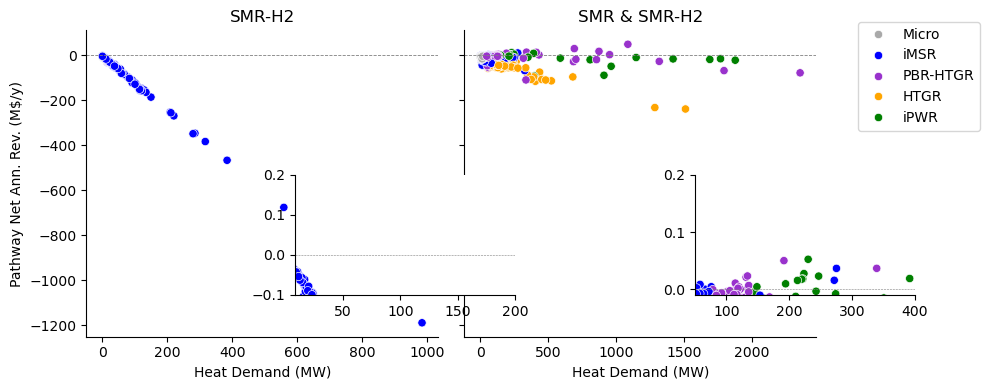

In [249]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(10,4))

sns.scatterplot(ax=ax[0], data=best_pathway[best_pathway.Pathway == 'SMR-H2'], x= 'Heat Demand (MW)', \
                y = 'Pathway Net Ann. Rev. (M$/y)', hue='SMR', palette=utils.palette)
sns.scatterplot(ax=ax[1], data=best_pathway[best_pathway.Pathway == 'SMR+SMR-H2'], x= 'Heat Demand (MW)', \
                y = 'Pathway Net Ann. Rev. (M$/y)', hue='SMR', palette=utils.palette)
ax[0].axhline(0, color='grey', linestyle='--', linewidth=0.6)
ax[0].set_title('SMR-H2')
ax[0].get_legend().set_visible(False)
ax[1].axhline(0, color='grey', linestyle='--', linewidth=0.6)
ax[1].set_title('SMR & SMR-H2')
ax[1].legend(bbox_to_anchor=(1.1, 1.05))
# Zoom of ANR and ANR-H2
# this is an inset axes over the main axes
sub_ax = plt.axes([.7, .25, .22, .3]) 
sns.scatterplot(ax=sub_ax, data=best_pathway[best_pathway.Pathway == 'SMR+SMR-H2'], x= 'Heat Demand (MW)', y = 'Pathway Net Ann. Rev. (M$/y/MWt)', hue='SMR', palette=utils.palette)
sub_ax.axhline(0, color='grey', linestyle='--', linewidth=0.4)
sub_ax.set_xlim(50,400)
sub_ax.set_ylim(-.01, 0.2)
sub_ax.get_legend().set_visible(False)
sub_ax.set_xlabel('')
sub_ax.set_ylabel('')
# Zoom of ANR-H2
# this is an inset axes over the main axes
sub_ax = plt.axes([.3, .25, .22, .3]) 
sns.scatterplot(ax=sub_ax, data=best_pathway[best_pathway.Pathway == 'SMR-H2'], x= 'Heat Demand (MW)', y = 'Pathway Net Ann. Rev. (M$/y/MWt)', hue='SMR', palette=utils.palette)
sub_ax.axhline(0, color='grey', linestyle='--', linewidth=0.4)
sub_ax.set_xlim(8,200)
sub_ax.set_ylim(-0.1,0.2)
#sub_ax.set_ylim(-.01, 0.2)
sub_ax.get_legend().set_visible(False)
sub_ax.set_xlabel('')
sub_ax.set_ylabel('')
sns.despine()
fig.tight_layout()
fig.savefig(f'./results/process_heat/best_net_ann_rev_vs_heat_demand_{OAK}_{cogen_tag}_PTC_{with_PTC}.png')

Very small demand are the least profitable to serve, and we observe that for ANR-H2 pathway the most profitable plants require a demand between 50 and 100 MWt while for the ANR & ANR-H2 pathway a profitability maximum is observed between 200 and 300 MWt. 

No clear influence of remaining heat on profitability

### Influence of surplus capacity on profitability

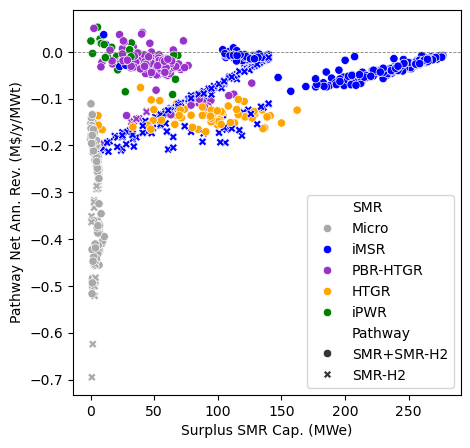

In [250]:
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(ax=ax, data=best_pathway, x= 'Surplus SMR Cap. (MWe)', y = 'Pathway Net Ann. Rev. (M$/y/MWt)', hue='SMR', style='Pathway', palette=utils.palette)
ax.axhline(0, color='grey', linestyle='--', linewidth=0.6)

### Net Annual Revenues per Industry

In [251]:
map_id_industry =pd.read_excel('./input_data/direct_heat_maxv/maxv_heat_data_old.xlsx')[['FACILITY_ID', 'Industry']]
map_id_industry.drop_duplicates(inplace=True, ignore_index=True)
best_pathway_mapped = best_pathway.merge(map_id_industry, on='FACILITY_ID', how='left')
best_pathway_mapped['Industry'] = best_pathway_mapped['Industry'].fillna('Other')
best_pathway_mapped.replace({'Other_Not Found':'Other'}, inplace=True)

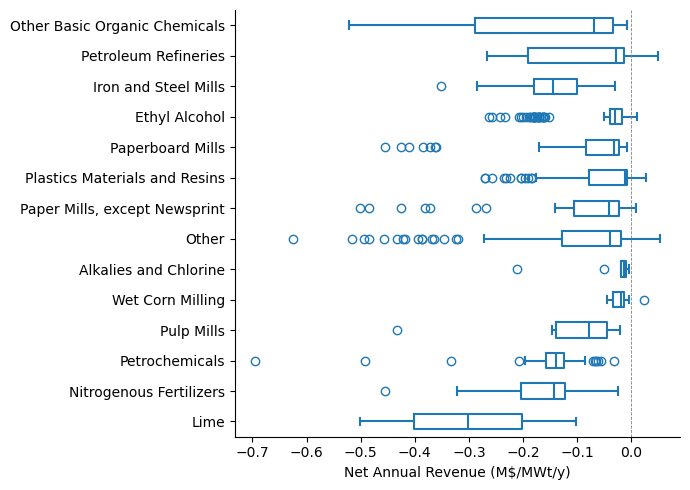

In [252]:
save_path = f'./results/process_heat/best_net_ann_rev_vs_industry_{OAK}_{cogen_tag}_PTC_{with_PTC}.png'
fig, ax = plt.subplots(figsize=(7,5))
sns.boxplot(ax=ax, data=best_pathway_mapped, y='Industry', x='Pathway Net Ann. Rev. (M$/y/MWt)',fill=False, width=.5)
ax.set_ylabel('')
ax.set_xlabel('Net Annual Revenue (M$/MWt/y)')
sns.despine()
ax.axvline(0, color='grey', linestyle='--', linewidth=0.6)
#ax.legend(bbox_to_anchor=(-0.1, .01))

fig.tight_layout()
fig.savefig(save_path)

### Cost comparison against NG with CCUS

Cost of NG+CCUS = Avoided NG Cost + Emissions x CCUS Cost

Cost of ANR = CAPEX + O&M + Conversion - H2 PTC 

In [253]:
comp_ccus = best_pathway_mapped.copy()
# Plot only profitable facilities
comp_ccus = comp_ccus[comp_ccus['Pathway Net Ann. Rev. (M$/y)']>=0]
comp_ccus['Cost NG + CCUS (M$/MWt/y)'] = (comp_ccus['Avoided NG Cost ($/y)']+comp_ccus['Emissions_mmtco2/y']*utils.ccus_cost*1e6)/(comp_ccus['Depl. ANR Cap. (MWt)']*1e6)
if cogen: comp_ccus['Cost SMR deployment (M$/MWt/y)'] = (comp_ccus['CAPEX ($/y)']+comp_ccus['O&M ($/y)']+comp_ccus['Conversion']-\
                                                comp_ccus['H2 PTC']-comp_ccus['Electricity revenues ($/y)'])/(comp_ccus['Depl. ANR Cap. (MWt)']*1e6)
else: comp_ccus['Cost SMR deployment (M$/MWt/y)'] = (comp_ccus['CAPEX ($/y)']+comp_ccus['O&M ($/y)']+comp_ccus['Conversion']-\
                                                comp_ccus['H2 PTC'])/(comp_ccus['Depl. ANR Cap. (MWt)']*1e6)

In [254]:
comp_ccus = comp_ccus.rename(columns={'Emissions_mmtco2/y': 'Emissions (MMtCO2/y)'})

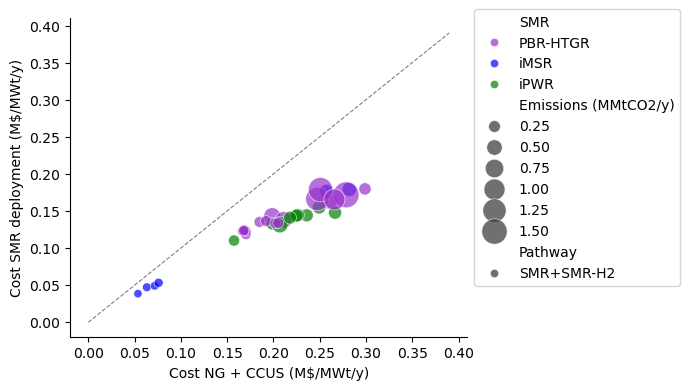

In [255]:
save_path = f'./results/process_heat/best_comparison_costs_vs_ccus_anr_{OAK}_{cogen_tag}_PTC_{with_PTC}.png'

fig, ax = plt.subplots(figsize=(7,4))
med_x = np.arange(0,0.4, 0.01)

sns.scatterplot(ax=ax, data=comp_ccus, y='Cost SMR deployment (M$/MWt/y)', x='Cost NG + CCUS (M$/MWt/y)', hue='SMR',\
                 size='Emissions (MMtCO2/y)', sizes=(20,500), size_norm=(0,2.3), style='Pathway',palette=utils.palette, alpha=.7)
ax.plot(med_x, med_x, color='grey', linestyle='--', linewidth=0.8)
ax.spines[['right', 'top']].set_visible(False)
ax.legend(bbox_to_anchor=(1, 1.05), )

fig.tight_layout()
fig.savefig(save_path)

### Emissions abatement costs

In [357]:
best_pathway.columns

Index(['FACILITY_ID', 'STATE', 'CITY', 'latitude', 'longitude',
       'Batch_Temp_degC', 'max_temp_degC', 'Emissions_mmtco2/y',
       'Emissions_batch_mmtco2/y', 'Emissions_rem_mmtco2/y',
       'Heat Demand (MW)', 'Remaining_Heat_MW', 'Remaining_temp_degC',
       'Annual_CAPEX_NOAK', 'FOPEX_NOAK', 'VOPEX_NOAK', 'NG_HLMP_mod',
       'NG Mult (MMBtu/MJ)', 'NG price ($/MMBtu)',
       'ANR Net Ann. Rev. NOAK ($/year)', 'IRR w PTC', 'IRR wo PTC',
       'H2 Dem. (kg/h)', 'Technology', 'SMR', 'H2 Modules', 'ANR Modules',
       'ANR CAPEX ($/MWe)', 'Annual ANR CAPEX', 'Annual H2 CAPEX', 'ANR CRF',
       'Annual ANR-H2 CAPEX', 'ANR-H2 FOM', 'H2 VOM', 'H2 FOM', 'ANR VOM',
       'ANR FOM', 'ANR-H2 VOM', 'Conversion', 'ANR-H2 Total Cost ($/year)',
       'Avoided NG Cost ($/y)', 'H2 PTC', 'Electricity revenues ($/y)',
       'Depl. ANR Cap. (MWe)', 'Depl. ANR Cap. (MWt)',
       'Surplus SMR Cap. (MWe)', 'Surplus ANR Cap. (MWt)',
       'Net Ann. Rev. ($/year)', 'Pathway', 'Pathway Net A

In [358]:
em = best_pathway.copy()
em['Cost ANR ($/y)'] = (em['CAPEX ($/y)']+em['O&M ($/y)']+em['Conversion']-em['Avoided NG Cost ($/y)'])
em['Abatement cost ($/tCO2)'] = em['Cost ANR ($/y)']/(em['Emissions_mmtco2/y']*1e6)
em['Abatement potential (tCO2/y-MWe)'] = 1e6*em['Emissions_mmtco2/y']/em['Depl. ANR Cap. (MWe)']
min_cost = min(em['Abatement cost ($/tCO2)'])
max_cost = max(em['Abatement cost ($/tCO2)'])
min_cost_anr = min(em['Cost ANR ($/y)'])
max_cost_anr = max(em['Cost ANR ($/y)'])
print(min_cost, max_cost)
print(min_cost_anr, max_cost_anr)
print(min(em['Emissions_mmtco2/y']), max(em['Emissions_mmtco2/y']))

465.4277158589871 8592188.720712947
5552167.866522168 1713938828.4119878
4.053e-06 3.399976439


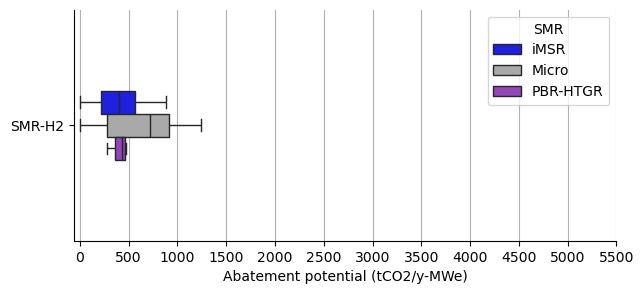

In [359]:
fig, ax = plt.subplots(figsize=(7,3))

sns.boxplot(ax=ax, data=em, y='Pathway', x='Abatement potential (tCO2/y-MWe)', palette=utils.palette, hue='SMR',width=0.3)
ax.set_ylabel('')
ax.xaxis.set_ticks(np.arange(0, 6000, 500))
sns.despine()
ax.xaxis.grid(True)
fig.savefig(f'./results/process_heat/best_abatement_potential_vs_pathway_anr_{OAK}_{cogen_tag}_PTC_{with_PTC}.png')

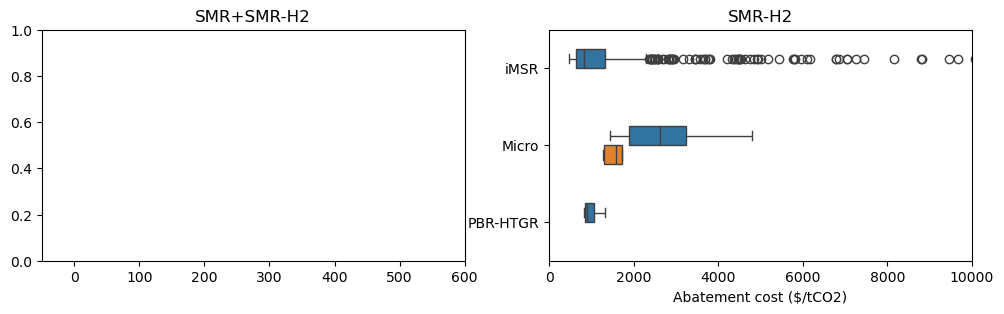

In [360]:
fig, ax = plt.subplots(1,2,figsize=(12,3))
sns.boxplot(ax=ax[0], data=em[em.Pathway=='SMR+SMR-H2'], y='SMR', x='Abatement cost ($/tCO2)', hue='Technology',width=0.5)
sns.boxplot(ax=ax[1], data=em[em.Pathway=='SMR-H2'], y='SMR', x='Abatement cost ($/tCO2)', hue='Technology',width=0.5)
ax[1].set_xlim(0,10000)
ax[1].set_title('SMR-H2')
ax[0].set_xlim(-50,600)
ax[0].set_title('SMR+SMR-H2')
ax[0].set_ylabel('')
ax[1].set_ylabel('')
ax[1].get_legend().set_visible(False)
fig.savefig(f'./results/process_heat/best_abatement_cost_vs_anr_h2tech_{OAK}_{cogen_tag}_PTC_{with_PTC}.png')

In [361]:
anr_anrh2 = best_pathway[best_pathway.Pathway == 'SMR+SMR-H2']
anr_anrh2['ANR-only Cost ($/y)'] = anr_anrh2['Annual ANR CAPEX']+anr_anrh2[f'VOPEX_{OAK}']+anr_anrh2[f'FOPEX_{OAK}']
anr_anrh2['ANR-H2-only Cost ($/y)'] = anr_anrh2['Annual ANR-H2 CAPEX']+anr_anrh2['ANR-H2 FOM']+anr_anrh2['ANR-H2 VOM']
anr_anrh2.columns

Index(['FACILITY_ID', 'STATE', 'CITY', 'latitude', 'longitude',
       'Batch_Temp_degC', 'max_temp_degC', 'Emissions_mmtco2/y',
       'Emissions_batch_mmtco2/y', 'Emissions_rem_mmtco2/y',
       'Heat Demand (MW)', 'Remaining_Heat_MW', 'Remaining_temp_degC',
       'Annual_CAPEX_NOAK', 'FOPEX_NOAK', 'VOPEX_NOAK', 'NG_HLMP_mod',
       'NG Mult (MMBtu/MJ)', 'NG price ($/MMBtu)',
       'ANR Net Ann. Rev. NOAK ($/year)', 'IRR w PTC', 'IRR wo PTC',
       'H2 Dem. (kg/h)', 'Technology', 'SMR', 'H2 Modules', 'ANR Modules',
       'ANR CAPEX ($/MWe)', 'Annual ANR CAPEX', 'Annual H2 CAPEX', 'ANR CRF',
       'Annual ANR-H2 CAPEX', 'ANR-H2 FOM', 'H2 VOM', 'H2 FOM', 'ANR VOM',
       'ANR FOM', 'ANR-H2 VOM', 'Conversion', 'ANR-H2 Total Cost ($/year)',
       'Avoided NG Cost ($/y)', 'H2 PTC', 'Electricity revenues ($/y)',
       'Depl. ANR Cap. (MWe)', 'Depl. ANR Cap. (MWt)',
       'Surplus SMR Cap. (MWe)', 'Surplus ANR Cap. (MWt)',
       'Net Ann. Rev. ($/year)', 'Pathway', 'Pathway Net A

In [362]:
anr_anrh2['Abatement cost ANR ($/tCO2)'] = (anr_anrh2['ANR-only Cost ($/y)']-anr_anrh2['Avoided NG Cost ($/y)'])/(anr_anrh2['Emissions_batch_mmtco2/y']*1e6)
anr_anrh2['Abatement cost ANR-H2 ($/tCO2)'] = (anr_anrh2['ANR-H2-only Cost ($/y)']-anr_anrh2['Avoided NG Cost ($/y)'])/(anr_anrh2['Emissions_rem_mmtco2/y']*1e6)

### Influence of temperature on profitability

No influence of max temperature at facility on profitability

### Comparison against NG without CCUS

In [363]:
comp_ccus['Cost NG without CCUS (M$/MWt/y)'] = comp_ccus['Avoided NG Cost ($/y)']/(comp_ccus['Depl. ANR Cap. (MWt)']*1e6)
comp_ccus.columns

Index(['FACILITY_ID', 'STATE', 'CITY', 'latitude', 'longitude',
       'Batch_Temp_degC', 'max_temp_degC', 'Emissions (MMtCO2/y)',
       'Emissions_batch_mmtco2/y', 'Emissions_rem_mmtco2/y',
       'Heat Demand (MW)', 'Remaining_Heat_MW', 'Remaining_temp_degC',
       'Annual_CAPEX_NOAK', 'FOPEX_NOAK', 'VOPEX_NOAK', 'NG_HLMP_mod',
       'NG Mult (MMBtu/MJ)', 'NG price ($/MMBtu)',
       'ANR Net Ann. Rev. NOAK ($/year)', 'IRR w PTC', 'IRR wo PTC',
       'H2 Dem. (kg/h)', 'Technology', 'SMR', 'H2 Modules', 'ANR Modules',
       'ANR CAPEX ($/MWe)', 'Annual ANR CAPEX', 'Annual H2 CAPEX', 'ANR CRF',
       'Annual ANR-H2 CAPEX', 'ANR-H2 FOM', 'H2 VOM', 'H2 FOM', 'ANR VOM',
       'ANR FOM', 'ANR-H2 VOM', 'Conversion', 'ANR-H2 Total Cost ($/year)',
       'Avoided NG Cost ($/y)', 'H2 PTC', 'Electricity revenues ($/y)',
       'Depl. ANR Cap. (MWe)', 'Depl. ANR Cap. (MWt)',
       'Surplus SMR Cap. (MWe)', 'Surplus ANR Cap. (MWt)',
       'Net Ann. Rev. ($/year)', 'Pathway', 'Pathway Net

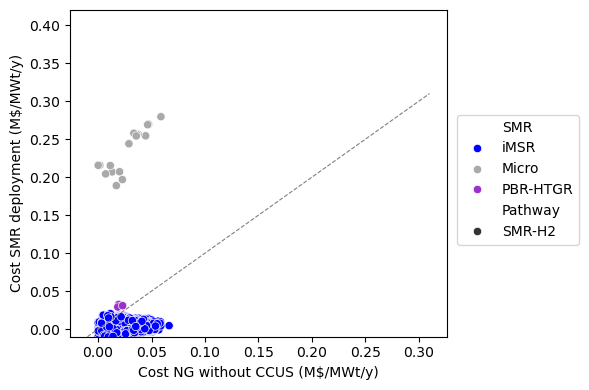

In [364]:
fig, ax = plt.subplots(sharey=True, figsize=(6,4))

sns.scatterplot(ax=ax, data=comp_ccus, x= 'Cost NG without CCUS (M$/MWt/y)', y = 'Cost SMR deployment (M$/MWt/y)', hue='SMR', style='Pathway', palette=utils.palette)
med_x = np.arange(-0.01,0.32, 0.01)
ax.plot(med_x, med_x, color='grey', linestyle='--', linewidth=0.8)
ax.legend(bbox_to_anchor=(1.01, .7))
ax.set_ylim(-0.01, 0.42)
fig.tight_layout()
fig.savefig(f'./results/process_heat/best_comparison_costs_vs_ng_wo_ccus_{OAK}_{cogen_tag}_PTC_{with_PTC}.png')


### Breakeven NG prices

In [365]:
bmp = best_pathway_mapped.copy()
bmp.columns

Index(['FACILITY_ID', 'STATE', 'CITY', 'latitude', 'longitude',
       'Batch_Temp_degC', 'max_temp_degC', 'Emissions_mmtco2/y',
       'Emissions_batch_mmtco2/y', 'Emissions_rem_mmtco2/y',
       'Heat Demand (MW)', 'Remaining_Heat_MW', 'Remaining_temp_degC',
       'Annual_CAPEX_NOAK', 'FOPEX_NOAK', 'VOPEX_NOAK', 'NG_HLMP_mod',
       'NG Mult (MMBtu/MJ)', 'NG price ($/MMBtu)',
       'ANR Net Ann. Rev. NOAK ($/year)', 'IRR w PTC', 'IRR wo PTC',
       'H2 Dem. (kg/h)', 'Technology', 'SMR', 'H2 Modules', 'ANR Modules',
       'ANR CAPEX ($/MWe)', 'Annual ANR CAPEX', 'Annual H2 CAPEX', 'ANR CRF',
       'Annual ANR-H2 CAPEX', 'ANR-H2 FOM', 'H2 VOM', 'H2 FOM', 'ANR VOM',
       'ANR FOM', 'ANR-H2 VOM', 'Conversion', 'ANR-H2 Total Cost ($/year)',
       'Avoided NG Cost ($/y)', 'H2 PTC', 'Electricity revenues ($/y)',
       'Depl. ANR Cap. (MWe)', 'Depl. ANR Cap. (MWt)',
       'Surplus SMR Cap. (MWe)', 'Surplus ANR Cap. (MWt)',
       'Net Ann. Rev. ($/year)', 'Pathway', 'Pathway Net A

In [366]:
bmp[['Remaining_temp_degC', 'Batch_Temp_degC', 'max_temp_degC']]

,Remaining_temp_degC,Batch_Temp_degC,max_temp_degC
0,NaN,NaN,900
1,NaN,NaN,600
2,NaN,NaN,1100
3,NaN,NaN,450
4,NaN,NaN,800
...,...,...,...
914,NaN,NaN,800
915,NaN,NaN,800
916,NaN,NaN,800
917,NaN,NaN,450


In [367]:
bmp['temp_served_degC'] = bmp['Batch_Temp_degC'].fillna(bmp['max_temp_degC'])
bmp['NG Mult (MMBtu/MJ)']  = bmp.apply(lambda x: compute_ng_multiplier(x['temp_served_degC']), axis=1) 
bmp['NG Mult (MMBtu/MJ)']

0      0.000534
1      0.000642
2      0.000462
3      0.000696
4      0.000570
         ...   
914    0.000570
915    0.000570
916    0.000570
917    0.000696
918    0.000696
Name: NG Mult (MMBtu/MJ), Length: 919, dtype: float64

In [368]:
# Recalculate NG multiplier from max temperature recorded

if cogen: bmp['Breakeven NG price ($/MMBtu)'] = (bmp['CAPEX ($/y)']+bmp['O&M ($/y)']+bmp['Conversion']-bmp['H2 PTC']-bmp['Electricity revenues ($/y)'])/\
                                              (bmp['NG Mult (MMBtu/MJ)']*bmp['Heat Demand (MW)']*utils.mwh_to_mj*8760)
else: bmp['Breakeven NG price ($/MMBtu)'] = (bmp['CAPEX ($/y)']+bmp['O&M ($/y)']+bmp['Conversion']-bmp['H2 PTC'])/\
                                              (bmp['NG Mult (MMBtu/MJ)']*bmp['Heat Demand (MW)']*utils.mwh_to_mj*8760)
if cogen: bmp['BE wo PTC ($/MMBtu)'] = (bmp['CAPEX ($/y)']+bmp['O&M ($/y)']+bmp['Conversion']-bmp['Electricity revenues ($/y)'])/\
                                              (bmp['NG Mult (MMBtu/MJ)']*bmp['Heat Demand (MW)']*utils.mwh_to_mj*8760)
else: bmp['BE wo PTC ($/MMBtu)'] = (bmp['CAPEX ($/y)']+bmp['O&M ($/y)']+bmp['Conversion'])/\
                                              (bmp['NG Mult (MMBtu/MJ)']*bmp['Heat Demand (MW)']*utils.mwh_to_mj*8760)
if cogen:
  bmp['Breakeven CAPEX ($/MWe)'] = (bmp['H2 PTC']+bmp['Electricity revenues ($/y)']+bmp['Avoided NG Cost ($/y)']-(bmp['Annual H2 CAPEX']+bmp['O&M ($/y)']+bmp['Conversion']))/(bmp['Depl. ANR Cap. (MWe)']*bmp['ANR CRF']*(1-utils.ITC_ANR))
  bmp['Breakeven CAPEX wo PTC ($/MWe)'] = (bmp['Electricity revenues ($/y)']+bmp['Avoided NG Cost ($/y)']\
  -(bmp['Annual H2 CAPEX']+bmp['O&M ($/y)']+bmp['Conversion']))/(bmp['Depl. ANR Cap. (MWe)']*bmp['ANR CRF']*(1-utils.ITC_ANR))
  # Cost reduction compared to capex 
  bmp['Cost red CAPEX BE'] = bmp.apply(lambda x:max(0,1-(x['Breakeven CAPEX ($/MWe)']/x['ANR CAPEX ($/MWe)'])), axis=1)
else: 
  bmp['Breakeven CAPEX ($/MWe)'] = (bmp['H2 PTC']+bmp['Avoided NG Cost ($/y)']\
  -(bmp['Annual H2 CAPEX']+bmp['O&M ($/y)']+bmp['Conversion']))/(bmp['Depl. ANR Cap. (MWe)']*bmp['ANR CRF']*(1-utils.ITC_ANR))
  bmp['Breakeven CAPEX wo PTC ($/MWe)'] = (bmp['Avoided NG Cost ($/y)']\
  -(bmp['Annual H2 CAPEX']+bmp['O&M ($/y)']+bmp['Conversion']))/(bmp['Depl. ANR Cap. (MWe)']*bmp['ANR CRF']*(1-utils.ITC_ANR))
  # Cost reduction compared to capex 
  bmp['Cost red CAPEX BE'] = bmp.apply(lambda x:max(0,1-(x['Breakeven CAPEX ($/MWe)']/x['ANR CAPEX ($/MWe)'])), axis=1)

max_ng = max(bmp['Breakeven NG price ($/MMBtu)'])
min_ng = min(bmp['Breakeven NG price ($/MMBtu)'])
print(f'Breakeven NG prices between {min_ng} and {max_ng} $/MMBtu')
bmp[['H2 PTC','Avoided NG Cost ($/y)','Annual H2 CAPEX','O&M ($/y)','Conversion','Electricity revenues ($/y)','Breakeven CAPEX ($/MWe)', 'Breakeven CAPEX wo PTC ($/MWe)', 'ANR CAPEX ($/MWe)']]

Breakeven NG prices between -53768.73047364797 and 13881.028845436238 $/MMBtu


,H2 PTC,Avoided NG Cost ($/y),Annual H2 CAPEX,O&M ($/y),Conversion,Electricity revenues ($/y),Breakeven CAPEX ($/MWe),Breakeven CAPEX wo PTC ($/MWe),ANR CAPEX ($/MWe)
0,1.817387e+07,3.385344e+06,1.970549e+06,1.487835e+07,2.429970e+06,2.119646e+07,3.053046e+06,6.896210e+05,3272800
1,3.227039e+07,6.011177e+06,3.526245e+06,1.901334e+07,4.302170e+06,2.030089e+07,4.127725e+06,-6.888328e+04,3272800
2,3.472257e+07,8.970582e+06,3.733672e+06,1.965950e+07,3.291176e+06,1.806660e+07,4.561388e+06,4.588539e+04,3272800
3,1.070883e+08,2.493199e+07,1.151215e+07,5.023426e+07,1.492613e+07,1.717001e+07,4.715292e+06,-2.247867e+06,3272800
4,2.573162e+07,5.990763e+06,2.800254e+06,1.709024e+07,3.409433e+06,2.350295e+07,4.151746e+06,8.054719e+05,3272800
...,...,...,...,...,...,...,...,...,...
914,1.797249e+07,4.184303e+06,1.970549e+06,1.484500e+07,2.343098e+06,2.921723e+07,4.189453e+06,1.852218e+06,3272800
915,1.983179e+05,4.617180e+04,4.020976e+04,9.810521e+06,2.627706e+04,4.009420e+07,3.961395e+06,3.935605e+06,3272800
916,1.518974e+07,3.166767e+06,1.659410e+06,1.402406e+07,2.012637e+06,2.675194e+07,3.564843e+06,1.589490e+06,3272800
917,1.415450e+07,2.950938e+06,1.555697e+06,1.373258e+07,1.972875e+06,2.387823e+07,3.084997e+06,1.244274e+06,3272800


In [369]:
pos_foak_noptc = bmp[bmp['Breakeven CAPEX wo PTC ($/MWe)']>bmp['ANR CAPEX ($/MWe)']]
pos_foak_noptc[['H2 PTC','Avoided NG Cost ($/y)','Annual H2 CAPEX','O&M ($/y)','Conversion','Electricity revenues ($/y)','Breakeven CAPEX ($/MWe)', 'Breakeven CAPEX wo PTC ($/MWe)', 'ANR CAPEX ($/MWe)', 'Pathway Net Ann. Rev. (M$/y)']]

,H2 PTC,Avoided NG Cost ($/y),Annual H2 CAPEX,O&M ($/y),Conversion,Electricity revenues ($/y),Breakeven CAPEX ($/MWe),Breakeven CAPEX wo PTC ($/MWe),ANR CAPEX ($/MWe),Pathway Net Ann. Rev. (M$/y)
16,5.458886e+06,1.265445e+06,622278.606640,1.121223e+07,687452.978274,3.803820e+07,4.192731e+06,3.482829e+06,3272800,7.073933
22,3.457894e+06,8.015878e+05,414852.404426,1.064079e+07,532700.034863,3.831183e+07,4.029187e+06,3.579504e+06,3272800,5.816337
24,4.999020e+06,1.158842e+06,622278.606640,1.113608e+07,700810.515349,3.783082e+07,4.100261e+06,3.450163e+06,3272800,6.362877
44,6.313175e+06,1.463482e+06,725991.707746,1.147374e+07,836493.788924,3.763133e+07,4.209791e+06,3.388793e+06,3272800,7.205116
59,4.901328e+04,1.265660e+04,40209.763127,9.663356e+06,5418.315571,3.945495e+07,3.876339e+06,3.869965e+06,3272800,4.640995
121,4.020051e+06,9.319037e+05,518565.505533,1.085392e+07,537508.135582,3.821991e+07,4.065456e+06,3.542667e+06,3272800,6.095234
157,1.983179e+05,4.617180e+04,40209.763127,9.810521e+06,26277.060622,4.009420e+07,3.961395e+06,3.935605e+06,3272800,5.295047
189,4.832568e+06,1.125105e+06,518565.505533,1.098847e+07,570573.329316,3.748785e+07,4.079246e+06,3.450794e+06,3272800,6.201275
219,3.598967e+06,9.297940e+05,414852.404426,1.066415e+07,448123.034236,3.599201e+07,3.770484e+06,3.302455e+06,3272800,3.827006
227,4.465760e+06,1.153184e+06,518565.505533,1.092773e+07,597102.382954,3.681528e+07,3.952180e+06,3.371429e+06,3272800,5.224183


In [370]:
pos_foak_noptc = bmp[bmp['Breakeven CAPEX ($/MWe)']>bmp['ANR CAPEX ($/MWe)']]
pos_foak_noptc[['H2 PTC','Avoided NG Cost ($/y)','Annual H2 CAPEX','O&M ($/y)','Conversion','Electricity revenues ($/y)','Breakeven CAPEX ($/MWe)', 'Breakeven CAPEX wo PTC ($/MWe)', 'ANR CAPEX ($/MWe)', 'Pathway Net Ann. Rev. (M$/y)']]

,H2 PTC,Avoided NG Cost ($/y),Annual H2 CAPEX,O&M ($/y),Conversion,Electricity revenues ($/y),Breakeven CAPEX ($/MWe),Breakeven CAPEX wo PTC ($/MWe),ANR CAPEX ($/MWe),Pathway Net Ann. Rev. (M$/y)
1,3.227039e+07,6.011177e+06,3.526245e+06,1.901334e+07,4.302170e+06,2.030089e+07,4.127725e+06,-6.888328e+04,3272800,6.574060
2,3.472257e+07,8.970582e+06,3.733672e+06,1.965950e+07,3.291176e+06,1.806660e+07,4.561388e+06,4.588539e+04,3272800,9.908770
3,1.070883e+08,2.493199e+07,1.151215e+07,5.023426e+07,1.492613e+07,1.717001e+07,4.715292e+06,-2.247867e+06,3272800,22.184477
4,2.573162e+07,5.990763e+06,2.800254e+06,1.709024e+07,3.409433e+06,2.350295e+07,4.151746e+06,8.054719e+05,3272800,6.758771
5,5.868116e+07,1.223388e+07,6.326499e+06,2.662804e+07,8.179069e+06,4.087264e+06,4.404461e+06,-3.226741e+06,3272800,8.702058
...,...,...,...,...,...,...,...,...,...,...
910,1.103206e+07,2.848787e+06,1.244557e+06,1.285539e+07,1.631330e+06,3.294769e+07,4.044050e+06,2.609383e+06,3272800,5.930628
914,1.797249e+07,4.184303e+06,1.970549e+06,1.484500e+07,2.343098e+06,2.921723e+07,4.189453e+06,1.852218e+06,3272800,7.048727
915,1.983179e+05,4.617180e+04,4.020976e+04,9.810521e+06,2.627706e+04,4.009420e+07,3.961395e+06,3.935605e+06,3272800,5.295047
916,1.518974e+07,3.166767e+06,1.659410e+06,1.402406e+07,2.012637e+06,2.675194e+07,3.564843e+06,1.589490e+06,3272800,2.245701


In [371]:
bmp[bmp['Pathway Net Ann. Rev. (M$/y)']>0]

,FACILITY_ID,STATE,CITY,latitude,longitude,Batch_Temp_degC,max_temp_degC,Emissions_mmtco2/y,Emissions_batch_mmtco2/y,Emissions_rem_mmtco2/y,...,O&M ($/y),ANR-H2 Net Ann. Rev. ($/year),Pathway Net Ann. Rev. (M$/y),Pathway Net Ann. Rev. (M$/y/MWt),Pathway Net Ann. Rev. (M$/y/MWe),Industry,temp_served_degC,Breakeven CAPEX ($/MWe),Breakeven CAPEX wo PTC ($/MWe),Cost red CAPEX BE
1,1000025,LA,PORT ALLEN,30.453350,-91.210057,NaN,600,0.050151,NaN,NaN,...,1.901334e+07,6.574060e+06,6.574060,0.021914,0.046625,Petroleum Refineries,600.0,4.127725e+06,-6.888328e+04,0.0
2,1000029,WA,SEATTLE,47.603832,-122.330062,NaN,1100,0.038366,NaN,NaN,...,1.965950e+07,9.908770e+06,9.908770,0.033029,0.070275,Iron and Steel Mills,1100.0,4.561388e+06,4.588539e+04,0.0
3,1000035,OH,GREENVILLE,40.102391,-84.633299,NaN,450,0.173995,NaN,NaN,...,5.023426e+07,2.218448e+07,22.184477,0.036974,0.078668,Ethyl Alcohol,450.0,4.715292e+06,-2.247867e+06,0.0
4,1000041,WI,MILWAUKEE,43.038648,-87.909075,NaN,800,0.039744,NaN,NaN,...,1.709024e+07,6.758771e+06,6.758771,0.022529,0.047935,Paperboard Mills,800.0,4.151746e+06,8.054719e+05,0.0
5,1000063,NE,HASTINGS,40.586132,-98.389888,NaN,450,0.095344,NaN,NaN,...,2.662804e+07,8.702058e+06,8.702058,0.029007,0.061717,Ethyl Alcohol,450.0,4.404461e+06,-3.226741e+06,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
910,1011859,PA,Monaca,40.687289,-80.271451,NaN,291,0.019017,NaN,NaN,...,1.285539e+07,5.930628e+06,5.930628,0.019769,0.042061,Plastics Materials and Resins,291.0,4.044050e+06,2.609383e+06,0.0
914,1011979,IN,Valparaiso,41.467255,-87.060449,NaN,800,0.027314,NaN,NaN,...,1.484500e+07,7.048727e+06,7.048727,0.023496,0.049991,Other,800.0,4.189453e+06,1.852218e+06,0.0
915,1012002,OH,Cincinnati,39.101454,-84.512460,NaN,800,0.000306,NaN,NaN,...,9.810521e+06,5.295047e+06,5.295047,0.017650,0.037554,Other,800.0,3.961395e+06,3.935605e+06,0.0
916,1012019,IA,Tama,42.056811,-92.543392,NaN,800,0.023461,NaN,NaN,...,1.402406e+07,2.245701e+06,2.245701,0.007486,0.015927,Paperboard Mills,800.0,3.564843e+06,1.589490e+06,0.0


In [389]:
pos_foak_noptc2 = bmp[bmp['BE wo PTC ($/MMBtu)']> bmp['NG price ($/MMBtu)']]
pos_foak_noptc2[['BE wo PTC ($/MMBtu)', 'NG price ($/MMBtu)', 'Pathway Net Ann. Rev. (M$/y)']]

,BE wo PTC ($/MMBtu),NG price ($/MMBtu),Pathway Net Ann. Rev. (M$/y)
0,69.600586,8.192015,-1.689830
1,44.593913,8.192015,6.574060
2,86.314855,11.361723,9.908770
3,41.069394,10.238829,22.184477
4,49.899395,25.597073,6.758771
...,...,...,...
913,47.590833,8.192015,-2.590643
914,43.942860,25.597073,7.048727
916,54.553411,22.921394,2.245701
917,52.475393,9.168558,-1.444133


<Axes: >

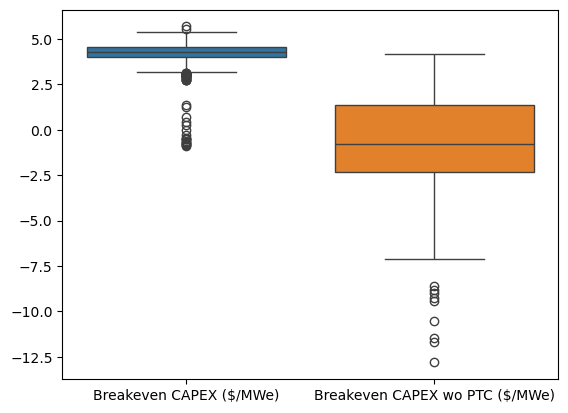

In [373]:
sns.boxplot(data=bmp[['Breakeven CAPEX ($/MWe)', 'Breakeven CAPEX wo PTC ($/MWe)']]/1e6)

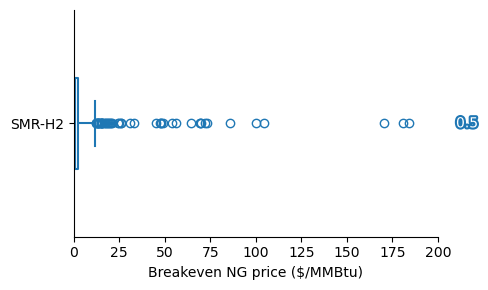

In [374]:
save_path = f'./results/process_heat/best_breakeven_ng_vs_pathway_{OAK}_{cogen_tag}_PTC_{with_PTC}.png'
fig, ax = plt.subplots(figsize=(5,3))
sns.boxplot(ax=ax, data=bmp, y='Pathway', x='Breakeven NG price ($/MMBtu)', hue='Pathway',fill=False, width=.4)
ax.set_xlim(0,200)
ax.set_ylabel('')
sns.despine()

import matplotlib.patheffects as path_effects


def add_median_labels_outside(ax: plt.Axes, fmt: str = ".1f") -> None:
    """Add text labels to the median lines of a seaborn boxplot.

    Args:
        ax: plt.Axes, e.g. the return value of sns.boxplot()
        fmt: format string for the median value
    """
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if "Patch" in str(c)]
    start = 4
    if not boxes:  # seaborn v0.13 => fill=False => no patches => +1 line
        boxes = [c for c in ax.get_lines() if len(c.get_xdata()) == 5]
        start += 1
    lines_per_box = len(lines) // len(boxes)
    for median in lines[start::lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if len(set(median.get_xdata())) == 1 else y
        xleftlim,xrightlim = ax.get_xlim()
        text = ax.text(xrightlim*1.08, y, f'{value:{fmt}}', ha='center', va='center', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])
add_median_labels_outside(ax)
fig.tight_layout()
fig.savefig(save_path)

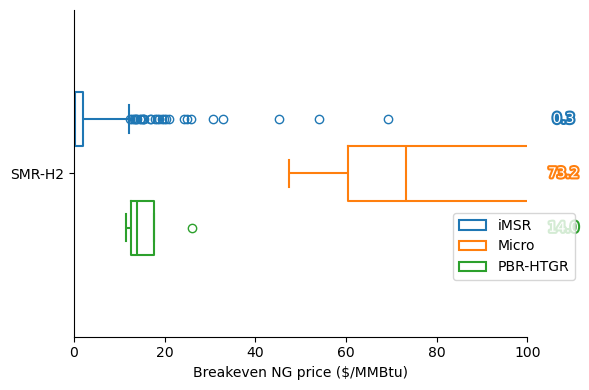

In [375]:
save_path = f'./results/process_heat/best_breakeven_ng_vs_pathway_anr_{OAK}_{cogen_tag}_PTC_{with_PTC}.png'
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(ax=ax, data=bmp, y='Pathway', x='Breakeven NG price ($/MMBtu)', hue='SMR',fill=False, width=.5)
ax.set_ylabel('')
ax.set_xlim(0,100)
sns.despine()
ax.legend(bbox_to_anchor=(1.12, .4))

add_median_labels_outside(ax)
fig.tight_layout()
fig.savefig(save_path)

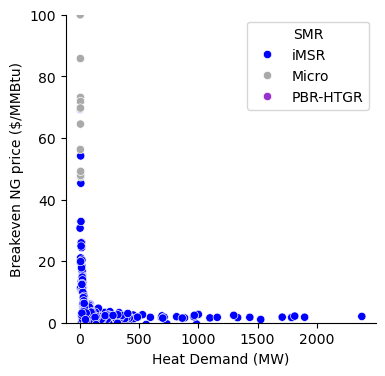

In [376]:
# Scatter plots: Heat demand
fig, ax = plt.subplots(sharey=True, figsize=(4,4))

sns.scatterplot(ax=ax, data=bmp, x= 'Heat Demand (MW)', y = 'Breakeven NG price ($/MMBtu)', hue='SMR', palette=utils.palette)

ax.set_ylim(0,100)
sns.despine()
fig.savefig(f'./results/process_heat/best_be_ng_vs_heat_demand_{OAK}_{cogen_tag}_PTC_{with_PTC}.png')

### Calculation abatement cost and potential

In [377]:
bmp.columns

Index(['FACILITY_ID', 'STATE', 'CITY', 'latitude', 'longitude',
       'Batch_Temp_degC', 'max_temp_degC', 'Emissions_mmtco2/y',
       'Emissions_batch_mmtco2/y', 'Emissions_rem_mmtco2/y',
       'Heat Demand (MW)', 'Remaining_Heat_MW', 'Remaining_temp_degC',
       'Annual_CAPEX_NOAK', 'FOPEX_NOAK', 'VOPEX_NOAK', 'NG_HLMP_mod',
       'NG Mult (MMBtu/MJ)', 'NG price ($/MMBtu)',
       'ANR Net Ann. Rev. NOAK ($/year)', 'IRR w PTC', 'IRR wo PTC',
       'H2 Dem. (kg/h)', 'Technology', 'SMR', 'H2 Modules', 'ANR Modules',
       'ANR CAPEX ($/MWe)', 'Annual ANR CAPEX', 'Annual H2 CAPEX', 'ANR CRF',
       'Annual ANR-H2 CAPEX', 'ANR-H2 FOM', 'H2 VOM', 'H2 FOM', 'ANR VOM',
       'ANR FOM', 'ANR-H2 VOM', 'Conversion', 'ANR-H2 Total Cost ($/year)',
       'Avoided NG Cost ($/y)', 'H2 PTC', 'Electricity revenues ($/y)',
       'Depl. ANR Cap. (MWe)', 'Depl. ANR Cap. (MWt)',
       'Surplus SMR Cap. (MWe)', 'Surplus ANR Cap. (MWt)',
       'Net Ann. Rev. ($/year)', 'Pathway', 'Pathway Net A

In [378]:
bmp[['IRR w PTC']]

,IRR w PTC
0,0.08
1,0.11
2,0.13
3,0.13
4,0.11
...,...
914,0.12
915,0.11
916,0.10
917,0.08


In [379]:
bmp['Cost ANR ($/y)'] = bmp['CAPEX ($/y)']+bmp['O&M ($/y)']+bmp['Conversion']-bmp['Avoided NG Cost ($/y)']
bmp['Abatement cost ($/tCO2)'] = bmp['Cost ANR ($/y)']/(bmp['Emissions_mmtco2/y']*1e6)
bmp['Abatement potential (tCO2/y-MWe)'] = 1e6*bmp['Emissions_mmtco2/y']/bmp['Depl. ANR Cap. (MWe)']

### Save results

In [380]:
bmp.to_excel(f'./results/process_heat/best_pathway_{OAK}_{cogen_tag}_PTC_{with_PTC}.xlsx')

### Cashflows breakdown

In [381]:
color_map = {'SMR CAPEX': 'navy', 
             'SMR for H2 CAPEX': 'royalblue',
               'H2 CAPEX': 'lightsteelblue', 
               'SMR O&M':'darkgreen', 
               'SMR for H2 O&M':'forestgreen', 
               'H2 O&M':'palegreen',
               'Avoided Fossil Fuel Costs':'darkorchid', 
               'H2 PTC':'plum', 
               'Electricity':'pink'}
best_pathway.columns



Index(['FACILITY_ID', 'STATE', 'CITY', 'latitude', 'longitude',
       'Batch_Temp_degC', 'max_temp_degC', 'Emissions_mmtco2/y',
       'Emissions_batch_mmtco2/y', 'Emissions_rem_mmtco2/y',
       'Heat Demand (MW)', 'Remaining_Heat_MW', 'Remaining_temp_degC',
       'Annual_CAPEX_NOAK', 'FOPEX_NOAK', 'VOPEX_NOAK', 'NG_HLMP_mod',
       'NG Mult (MMBtu/MJ)', 'NG price ($/MMBtu)',
       'ANR Net Ann. Rev. NOAK ($/year)', 'IRR w PTC', 'IRR wo PTC',
       'H2 Dem. (kg/h)', 'Technology', 'SMR', 'H2 Modules', 'ANR Modules',
       'ANR CAPEX ($/MWe)', 'Annual ANR CAPEX', 'Annual H2 CAPEX', 'ANR CRF',
       'Annual ANR-H2 CAPEX', 'ANR-H2 FOM', 'H2 VOM', 'H2 FOM', 'ANR VOM',
       'ANR FOM', 'ANR-H2 VOM', 'Conversion', 'ANR-H2 Total Cost ($/year)',
       'Avoided NG Cost ($/y)', 'H2 PTC', 'Electricity revenues ($/y)',
       'Depl. ANR Cap. (MWe)', 'Depl. ANR Cap. (MWt)',
       'Surplus SMR Cap. (MWe)', 'Surplus ANR Cap. (MWt)',
       'Net Ann. Rev. ($/year)', 'Pathway', 'Pathway Net A

In [382]:
best_pathway['Annual ANR CAPEX']

913     2.516664e+07
914     2.516664e+07
915     2.516664e+07
916     5.033328e+07
917     2.516664e+07
            ...     
1827    2.516664e+07
1828    2.516664e+07
1829    2.516664e+07
1830    2.516664e+07
1831    2.516664e+07
Name: Annual ANR CAPEX, Length: 919, dtype: float64

In [383]:
cashflows_df_anr_anrh2 = best_pathway[best_pathway.Pathway=='SMR+SMR-H2']

cashflows_df_anr_anrh2['SMR CAPEX'] = -cashflows_df_anr_anrh2[f'Annual_CAPEX_{OAK}']/(1e6*cashflows_df_anr_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anr_anrh2['SMR for H2 CAPEX'] = -cashflows_df_anr_anrh2['Annual ANR CAPEX']/(1e6*cashflows_df_anr_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anr_anrh2['H2 CAPEX'] = -cashflows_df_anr_anrh2['Annual H2 CAPEX']/(1e6*cashflows_df_anr_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anr_anrh2['SMR O&M'] = -(cashflows_df_anr_anrh2[f'FOPEX_{OAK}']+cashflows_df_anr_anrh2[f'VOPEX_{OAK}'])/(1e6*cashflows_df_anr_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anr_anrh2['SMR for H2 O&M'] = -(cashflows_df_anr_anrh2['ANR VOM']+cashflows_df_anr_anrh2['ANR FOM'])/(1e6*cashflows_df_anr_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anr_anrh2['H2 O&M'] = -(cashflows_df_anr_anrh2['H2 VOM']+cashflows_df_anr_anrh2['H2 FOM'])/(1e6*cashflows_df_anr_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anr_anrh2['Avoided Fossil Fuel Costs'] = cashflows_df_anr_anrh2['Avoided NG Cost ($/y)']/(1e6*cashflows_df_anr_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anr_anrh2['H2 PTC'] = cashflows_df_anr_anrh2['H2 PTC']/(1e6*cashflows_df_anr_anrh2['Depl. ANR Cap. (MWe)'])
if cogen: cashflows_df_anr_anrh2['Electricity'] = cashflows_df_anr_anrh2['Electricity revenues ($/y)']/(1e6*cashflows_df_anr_anrh2['Depl. ANR Cap. (MWe)'])


cashflows_df_anrh2 = best_pathway[best_pathway.Pathway=='SMR-H2']

cashflows_df_anrh2['SMR CAPEX'] = 0
cashflows_df_anrh2['SMR for H2 CAPEX'] = -cashflows_df_anrh2['Annual ANR CAPEX']/(1e6*cashflows_df_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anrh2['H2 CAPEX'] = -cashflows_df_anrh2['Annual H2 CAPEX']/(1e6*cashflows_df_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anrh2['SMR O&M'] = 0
cashflows_df_anrh2['SMR for H2 O&M'] = -(cashflows_df_anrh2['ANR VOM']+cashflows_df_anrh2['ANR FOM'])/(1e6*cashflows_df_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anrh2['H2 O&M'] = -(cashflows_df_anrh2['H2 VOM']+cashflows_df_anrh2['H2 FOM'])/(1e6*cashflows_df_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anrh2['Avoided Fossil Fuel Costs'] = cashflows_df_anrh2['Avoided NG Cost ($/y)']/(1e6*cashflows_df_anrh2['Depl. ANR Cap. (MWe)'])
cashflows_df_anrh2['H2 PTC'] = cashflows_df_anrh2['H2 PTC']/(1e6*cashflows_df_anrh2['Depl. ANR Cap. (MWe)'])
if cogen: cashflows_df_anrh2['Electricity'] = cashflows_df_anrh2['Electricity revenues ($/y)']/(1e6*cashflows_df_anrh2['Depl. ANR Cap. (MWe)'])

In [384]:
if cogen:
  cashflows_df_anr_anrh2 = cashflows_df_anr_anrh2[['SMR', 'SMR CAPEX','SMR for H2 CAPEX','H2 CAPEX','SMR O&M','SMR for H2 O&M', 
                                                 'H2 O&M','Avoided Fossil Fuel Costs','H2 PTC', 'Electricity']]
  cashflows_df_anrh2 = cashflows_df_anrh2[['SMR', 'SMR CAPEX','SMR for H2 CAPEX','H2 CAPEX','SMR O&M','SMR for H2 O&M', 
                                                 'H2 O&M','Avoided Fossil Fuel Costs','H2 PTC', 'Electricity']]
else:
  cashflows_df_anr_anrh2 = cashflows_df_anr_anrh2[['SMR', 'SMR CAPEX','SMR for H2 CAPEX','H2 CAPEX','SMR O&M','SMR for H2 O&M', 
                                                 'H2 O&M','Avoided Fossil Fuel Costs','H2 PTC']]
  cashflows_df_anrh2 = cashflows_df_anrh2[['SMR', 'SMR CAPEX','SMR for H2 CAPEX','H2 CAPEX','SMR O&M','SMR for H2 O&M', 
                                                  'H2 O&M','Avoided Fossil Fuel Costs','H2 PTC']]

In [385]:
cashflows_df_anr_anrh2 = cashflows_df_anr_anrh2.groupby(['SMR']).mean()
cashflows_df_anrh2 = cashflows_df_anrh2.groupby(['SMR']).mean()

In [386]:
cashflows_df_anr_anrh2.to_excel(f'./results/process_heat/anr+anrh2_avg_cashflows_{OAK}_{cogen_tag}_PTC_{with_PTC}.xlsx')

In [387]:
cashflows_df_anrh2.to_excel(f'./results/process_heat/anrh2_avg_cashflows_{OAK}_{cogen_tag}_PTC_{with_PTC}.xlsx')

IndexError: index 0 is out of bounds for axis 0 with size 0

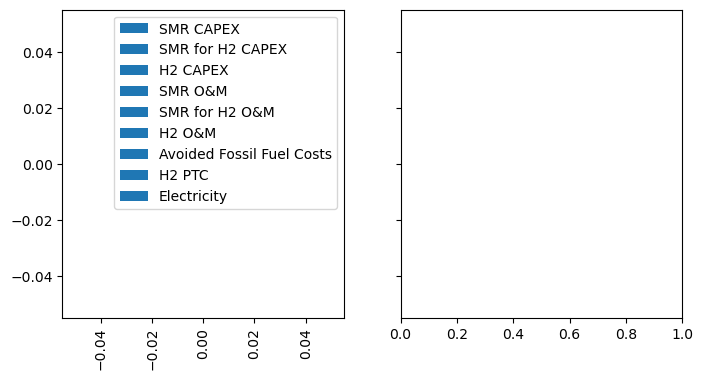

In [388]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
cashflows_df_anr_anrh2.plot(ax = ax[0], kind ='bar', stacked=True, color=color_map, width=0.4)
ax[0].set_ylabel('Average Normalized Cashflows (M$/MWt/y)')
ax[0].set_xlabel('')
ax[0].axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
ax[0].set_xticks(ax[0].get_xticks(), ax[0].get_xticklabels(), rotation=50, ha='right')
ax[0].set_ylim(-1.02, 0.52)
ax[0].yaxis.set_ticks(np.arange(-1.75, 1, 0.25))
ax[0].get_legend().set_visible(False)
ax[0].set_title('SMR+SMR-H2')

cashflows_df_anrh2.plot(ax = ax[1], kind ='bar', stacked=True, color=color_map, width=0.25)
ax[1].set_xlabel('')
ax[1].axhline(y=0, color='grey', linestyle='--', linewidth=0.5)
ax[1].set_xticks(ax[1].get_xticks(), ax[1].get_xticklabels(), rotation=50, ha='right')
ax[1].set_ylim(-1.02, 0.52)
ax[1].yaxis.set_ticks(np.arange(-1.75, 1, 0.25))
ax[1].get_legend().set_visible(False)
ax[1].set_title('SMR-H2')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels,  bbox_to_anchor=(.5,1.18),loc='upper center', ncol=3)
fig.tight_layout()
fig.savefig(f'./results/process_heat/best_avg_cashflows_vs_pathways_anr_{OAK}_{cogen_tag}_PTC_{with_PTC}.png')
  